<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW4_woodenML_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 25 января 23:59

**Продуктивной и интересной вам работы!**

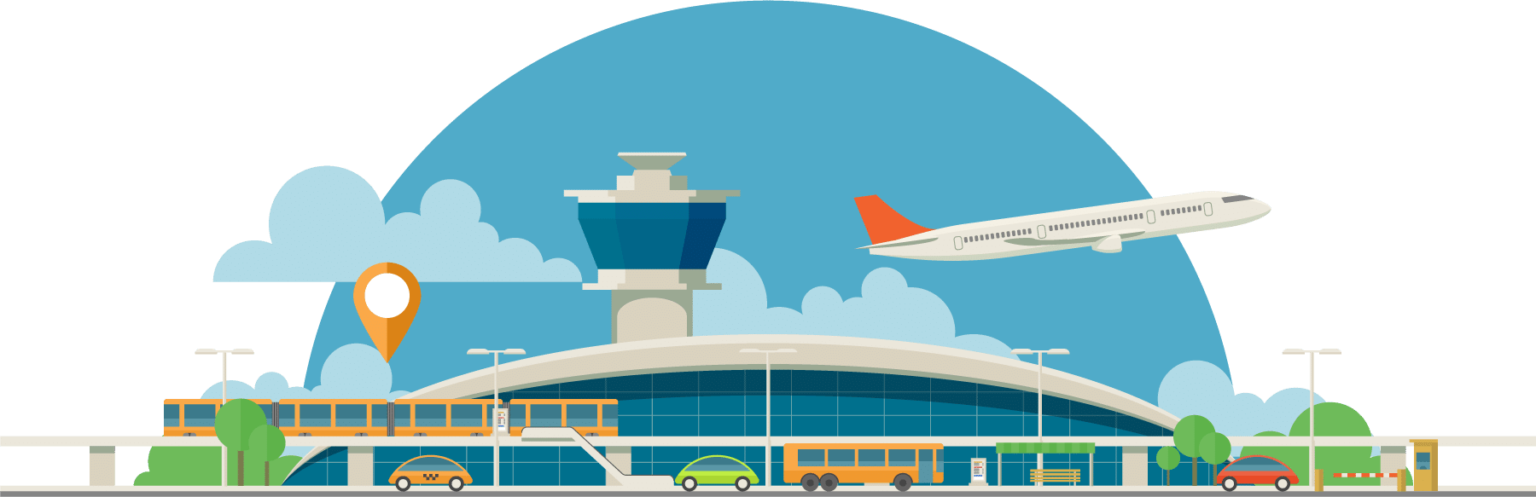

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from IPython.display import SVG

from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import CalibratedClassifierCV

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(42)
sns.set_theme(style="darkgrid")

# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

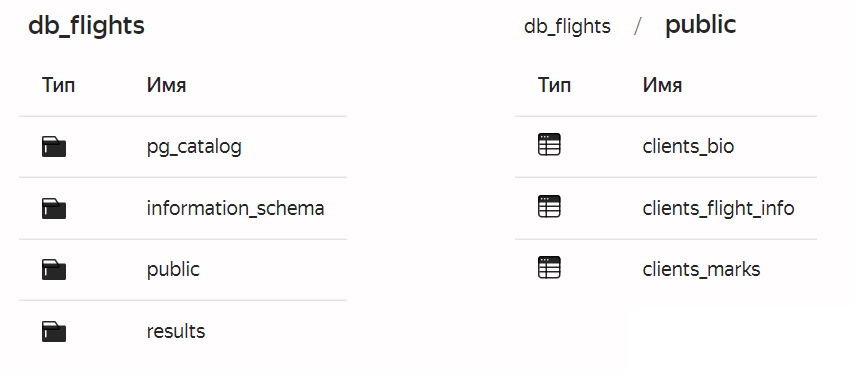



In [3]:
try:
    # Параметры подключения
    connection = psycopg2.connect(
        dbname="db_flights",
        user="mlhs_student",
        password="mlhs_student",
        host="rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
        port="6432" )

    print("Соединение с бд установлено!")
    cursor = connection.cursor()

    # SQL-запрос для объединения таблиц
    query = """
    SELECT 
        bio.*,
        flight_info.*,
        marks.*
    FROM 
        clients_bio AS bio
    LEFT JOIN 
        clients_flight_info AS flight_info
    ON 
        bio.id = flight_info.id
    LEFT JOIN 
        clients_marks AS marks
    ON 
        bio.id = marks.id"""
    
    # Выполнение запроса, получение данных и столбцов
    cursor.execute(query)
    result = cursor.fetchall()
    column_names = [desc[0] for desc in cursor.description]

except Exception as e:
    print("Ошибка при подключении или выполнении запроса:", e)

finally:
    # Закрытие соединения
    if connection:
        cursor.close()
        connection.close()
        print("Соединение закрыто.")


Соединение с бд установлено!
Соединение закрыто.


In [19]:
# Преобразование результата в DataFrame
df = pd.DataFrame(result, columns=column_names)

# Удалим дубликаты столбцов
df = df.loc[:, ~df.T.duplicated()]

# Устанавливаем id в качестве индекса
df = df.set_index(['id'])

In [21]:
# Сохраним, что каждый раз при перезапуске не делать запрос к БД
df.to_csv("hw4.csv", index=False)
df

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129838  Female  59.0     Loyal Customer  Personal Travel       Eco   
129839    Male  61.0     Loyal Customer  Personal Travel       Eco   
129846    Male  44.0     Loyal Customer  Personal Travel       Eco   
129868    Male  47.0     Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0     Loyal Customer  Personal Travel  Eco Plus   

       Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
id                                                                           
7               1963.0                        0.0                      0.0   
13               453.0                       16.0                     30.0   
18               821.0                        0.0                      0.0   
31               212.0                        0.0                      0.0   
39                67.0                        0.0                      0.0   
...                ...                        ...                      ...   
129838           308.0                       32.0                     24.0   
129839           337.0                        0.0                      0.0   
129846           447.0                        0.0                      0.0   
129868           447.0                        0.0                      0.0   
129876           447.0                        2.0                      3.0   

       Inflight wifi service Departure/Arrival time convenient  ...  \
id                                                              ...   
7                        3.0                               3.0  ...   
13                       2.0                               2.0  ...   
18                       2.0                               5.0  ...   
31                       2.0                               2.0  ...   
39                       3.0                               3.0  ...   
...                      ...                               ...  ...   
129838                   3.0                               5.0  ...   
129839                   2.0                               4.0  ...   
129846                   2.0                               5.0  ...   
129868                   3.0                               4.0  ...   
129876                   4.0                               4.0  ...   

       Online boarding Seat comfort Inflight entertainment On-board service  \
id                                                                            
7                  4.0          5.0                    5.0              5.0   
13                 2.0          5.0                    5.0              2.0   
18                 1.0          5.0                    5.0              5.0   
31                 2.0          2.0                    2.0              4.0   
39                 5.0          4.0                    4.0              4.0   
...                ...          ...                    ...              ...   
129838             5.0          5.0                    3.0              3.0   
129839             2.0          3.0                    3.0              4.0   
129846             2.0          5.0                    5.0              4.0   
129868             3.0          4.0                    4.0              2.0   
129876             4.0          1.0                    4.0              5.0   

       Leg room service Baggage handling Checkin service Inflight service  \
id                                                   

In [20]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [4]:
df = pd.read_csv('hw4.csv')

`Все числовые столбцы уже имеют тип данных float`

In [3]:
df.isna().sum().sort_values(ascending=0)

Arrival Delay in Minutes             507
age                                  315
class                                116
Departure Delay in Minutes           107
Type of Travel                       101
Flight Distance                       94
Customer Type                         77
Inflight service                      63
Food and drink                        50
Departure/Arrival time convenient     49
Baggage handling                      48
Seat comfort                          47
Leg room service                      46
Online boarding                       46
Inflight entertainment                45
Inflight wifi service                 44
On-board service                      44
Ease of Online booking                43
Checkin service                       42
cleanliness                           37
Gate location                         37
gender                                 0
satisfaction                           0
dtype: int64

`Больше всего пропусков в столбцах Arrival Delay in Minutes (507), age (315) и class (116)`

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df.describe(include='all')

gender            age   Customer Type   Type of Travel     class  \
count   129549  129234.000000          129472           129448    129433   
unique       2            NaN               2                2         3   
top     Female            NaN  Loyal Customer  Business travel  Business   
freq     65726            NaN          105763            89405     61939   
mean       NaN      40.116951             NaN              NaN       NaN   
std        NaN      20.376129             NaN              NaN       NaN   
min        NaN       0.000000             NaN              NaN       NaN   
25%        NaN      27.000000             NaN              NaN       NaN   
50%        NaN      40.000000             NaN              NaN       NaN   
75%        NaN      51.000000             NaN              NaN       NaN   
max        NaN     621.000000             NaN              NaN       NaN   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
count     129455.000000               129442.000000             129042.000000   
unique              NaN                         NaN                       NaN   
top                 NaN                         NaN                       NaN   
freq                NaN                         NaN                       NaN   
mean        1322.922158                   15.809026                 16.656499   
std         4517.816532                   93.276882                109.285072   
min            0.000000                    0.000000                  0.000000   
25%          414.000000                    0.000000                  0.000000   
50%          846.000000                    0.000000                  0.000000   
75%         1744.000000                   12.000000                 13.000000   
max       379620.000000                22227.000000              14006.000000   

        Inflight wifi service  Departure/Arrival time convenient  \
count           129505.000000                      129500.000000   
unique                    NaN                                NaN   
top                       NaN                                NaN   
freq                      NaN                                NaN   
mean                 2.732327                           3.062131   
std                  1.360033                           1.559627   
min                  0.000000                           0.000000   
25%                  2.000000                           2.000000   
50%                  3.000000                           3.000000   
75%                  4.000000                           4.000000   
max                 45.000000                          45.000000   

        Ease of Online booking  Gate location  Food and drink  \
count            129506.000000  129512.000000   129499.000000   
unique                     NaN            NaN             NaN   
top                        NaN            NaN             NaN   
freq                       NaN            NaN             NaN   
mean                  2.760722       2.981708        3.208141   
std                   1.431048       1.312873        1.357546   
min                   0.000000       0.000000        0.000000   
25%                   2.000000       2.000000        2.000000   
50%                   3.000000       3.000000        3.000000   
75%                   4.000000       4.000000        4.000000   
max                  45.000000      36.000000       45.000000   

        Online boarding   Seat comfort  Inflight entertainment  \
count     129503.000000  129502.000000           129504.000000   
unique              NaN            NaN                     NaN   
top                 NaN            NaN                     NaN   
freq                NaN            NaN                     NaN   
mean           3.256782       3.445669                3.361232   
std            1.381888       1.349713                1.366908   
min            0.000000       0.000000                0.000000

* `age` - максимальный возраст 621, явный выброс
* `Flight Distance` - минимальное значение 0 и максимальное 379620 являются выбросоми
* `Departure Delay in Minutes` - максимальное значение 22 227 минут (~15 дней) похоже на выброс 
* `Arrival Delay in Minutes` - максимальное значение 14 006 минут (~10 дней), что тоже похоже на выброс

### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

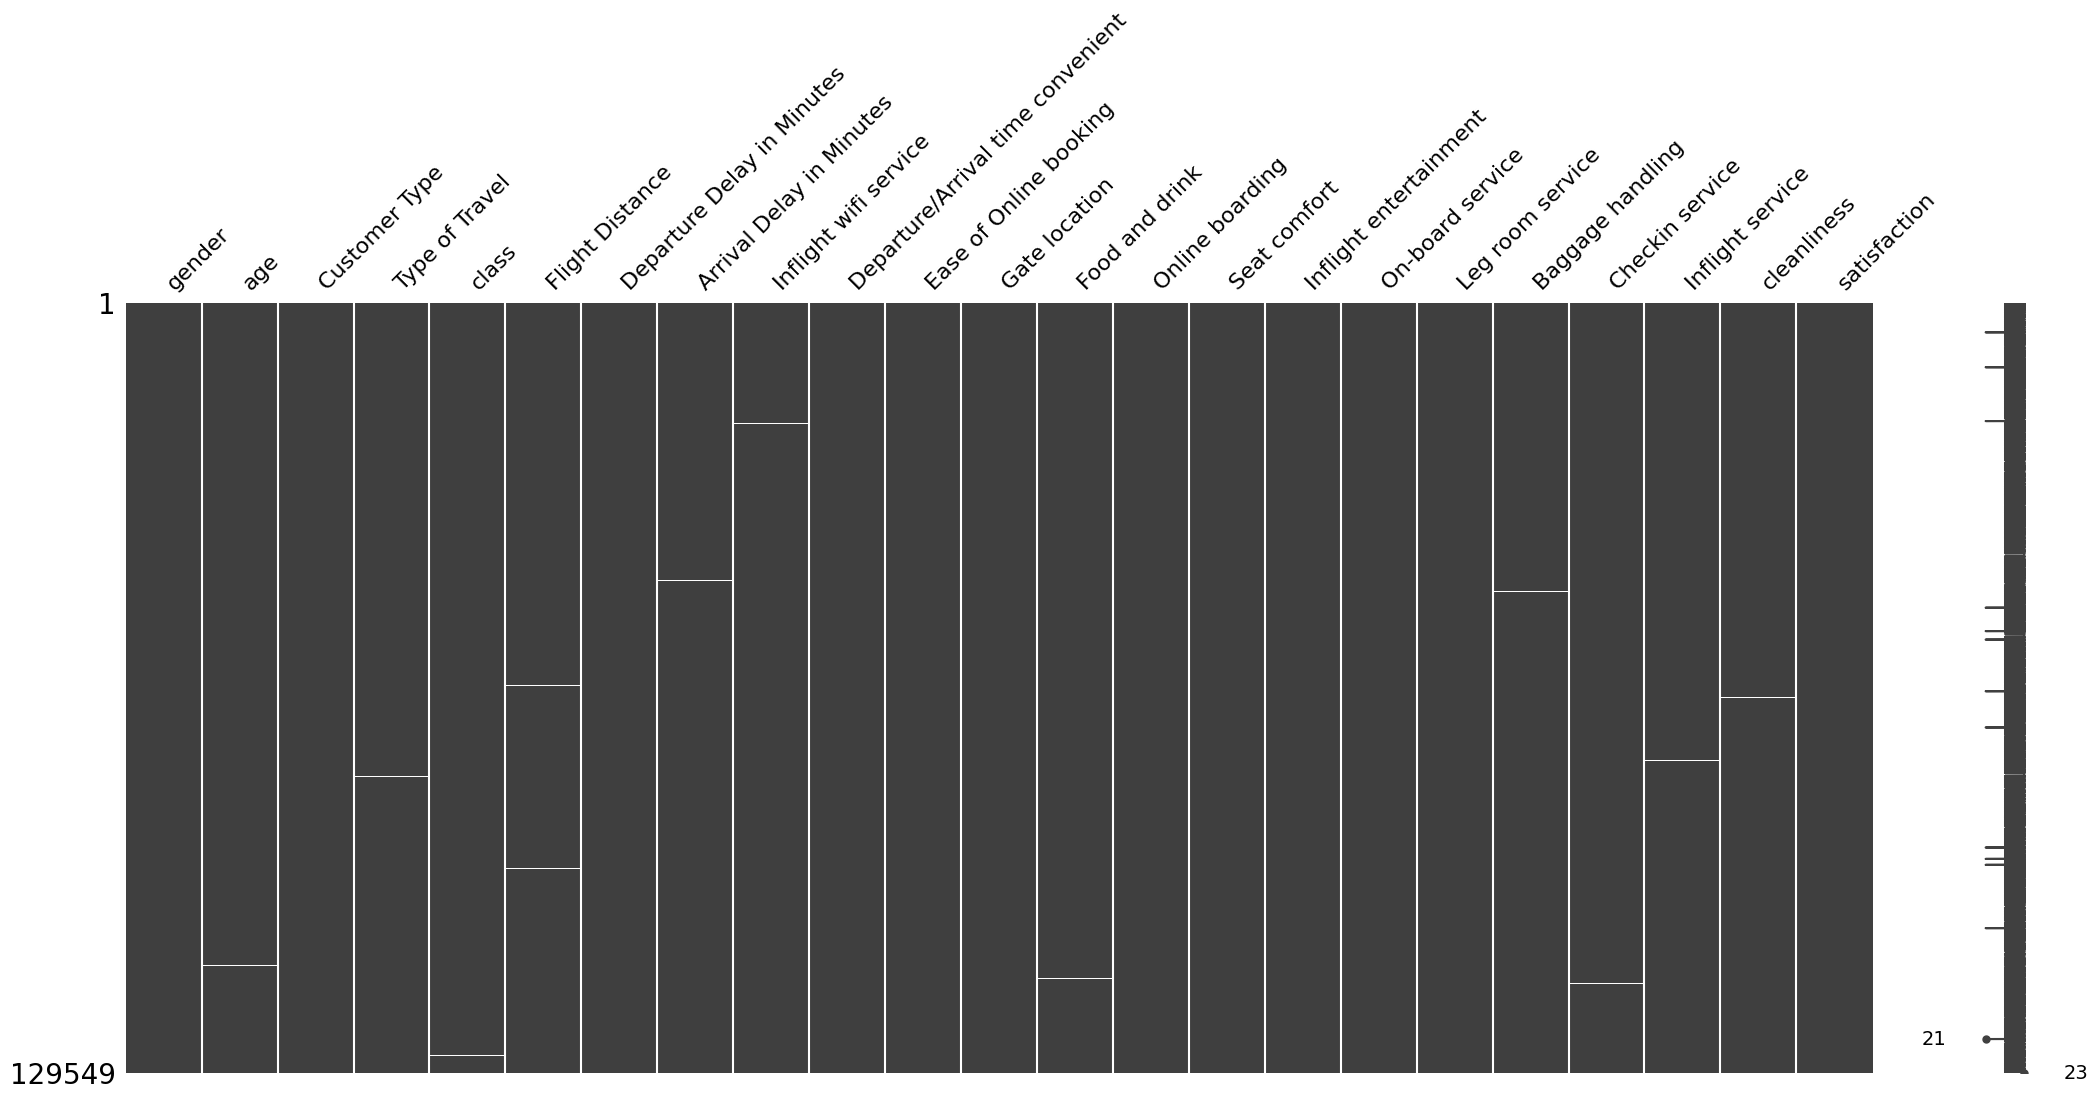

In [6]:
# Ваш код ниже
msno.matrix(df)
plt.show()

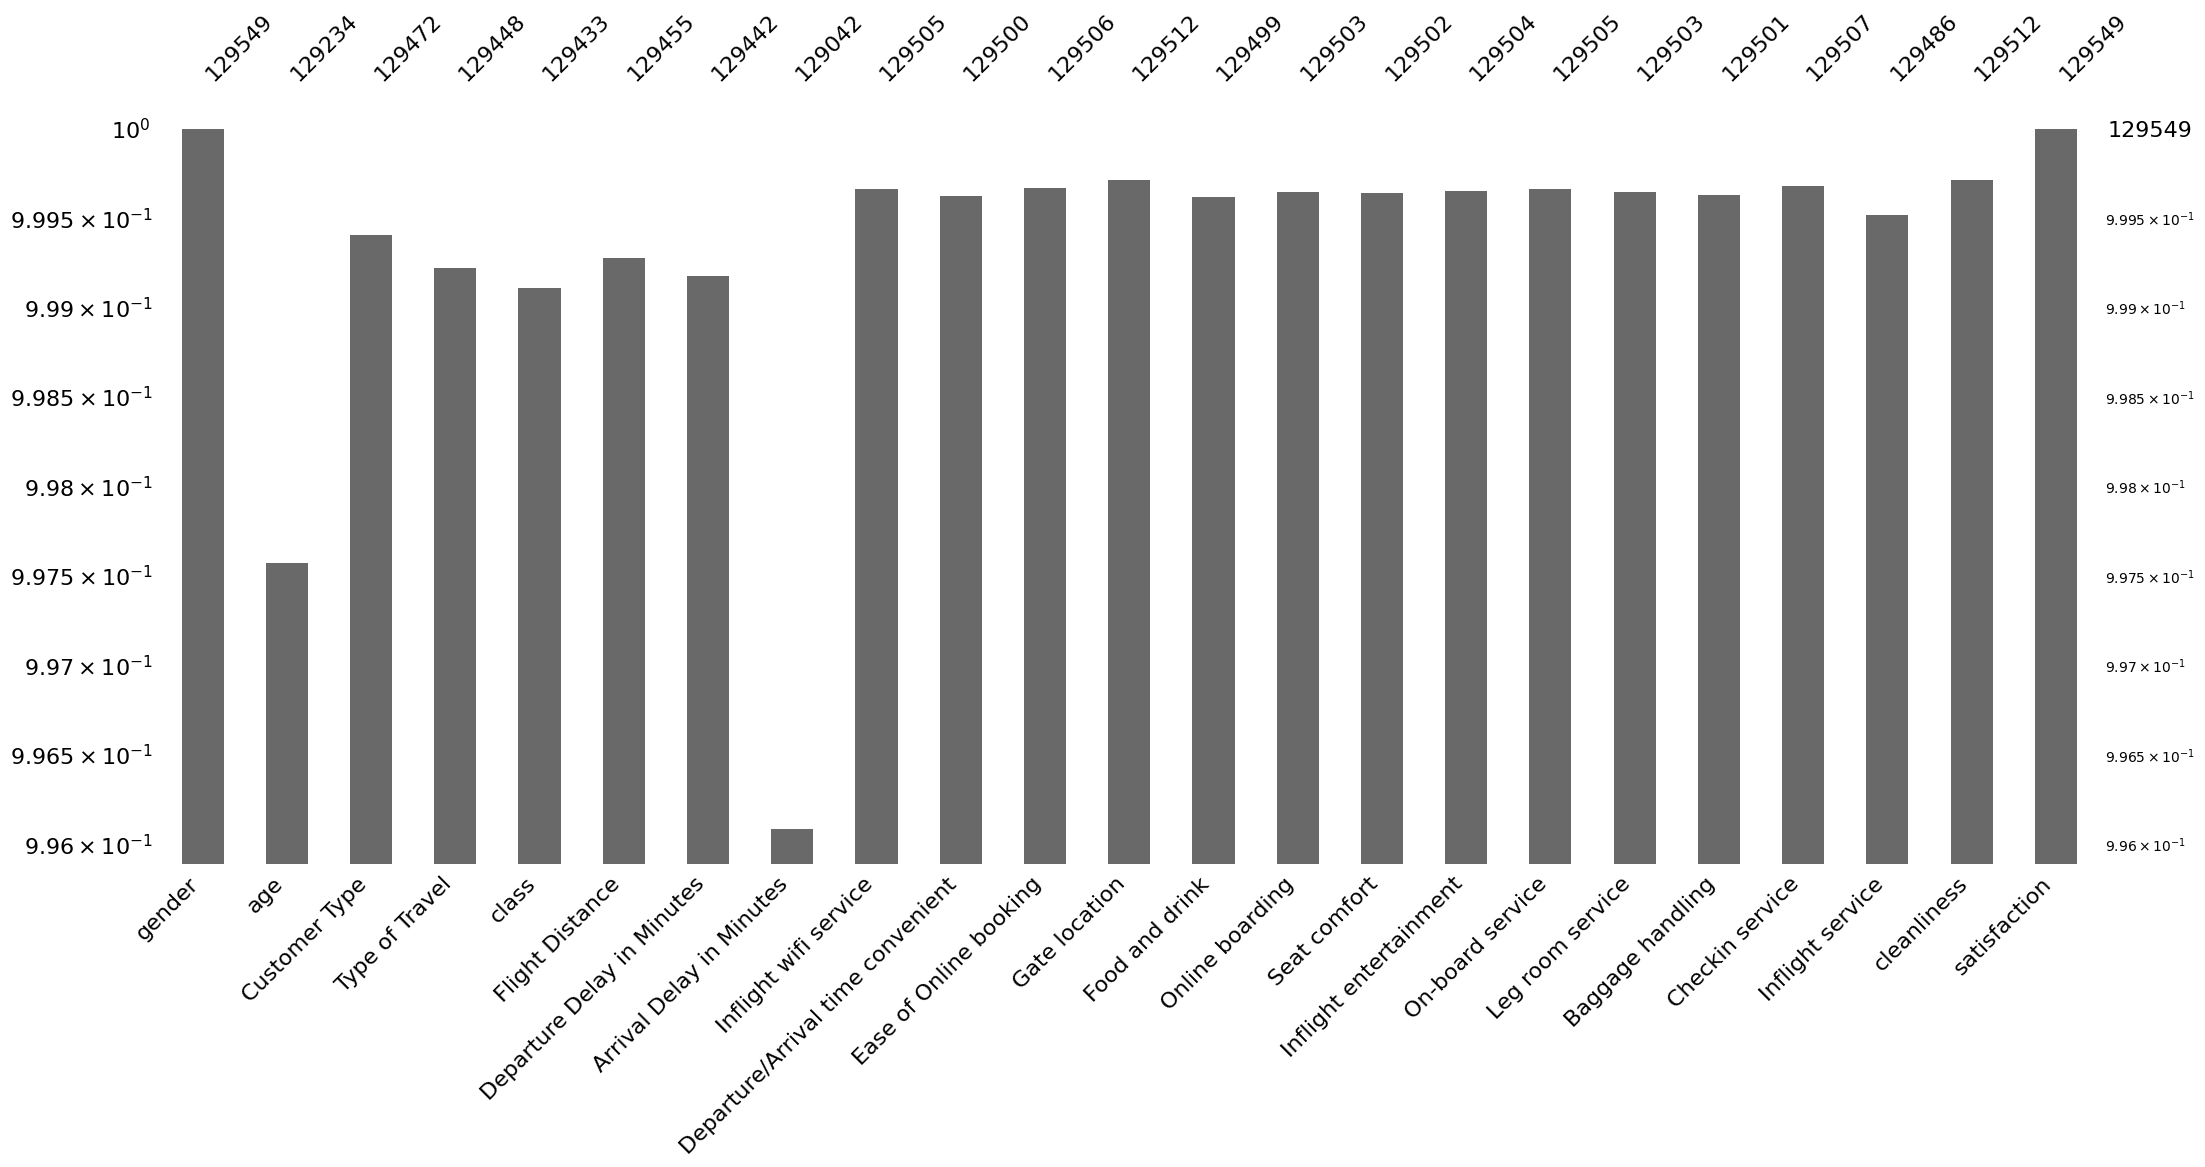

In [7]:
# Ваш код ниже
msno.bar(df, log=True)
plt.show()

`Графики пропусков в данных построили`

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [5]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
0         Male  43.0     Loyal Customer  Business travel  Business   
1         Male  24.0  disloyal Customer  Business travel       Eco   
2       Female  61.0     Loyal Customer  Personal Travel       Eco   
3         Male  35.0  disloyal Customer  Business travel  Business   
4       Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129542  Female  28.0     Loyal Customer  Personal Travel       Eco   
129543    Male  66.0     Loyal Customer  Personal Travel       Eco   
129544  Female  59.0     Loyal Customer  Personal Travel       Eco   
129545    Male  61.0     Loyal Customer  Personal Travel       Eco   
129546    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
0                1963.0                         0.0                       0.0   
1                 453.0                        16.0                      30.0   
2                 821.0                         0.0                       0.0   
3                 212.0                         0.0                       0.0   
4                  67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129542            447.0                        23.0                      16.0   
129543            337.0                       199.0                     213.0   
129544            308.0                        32.0                      24.0   
129545            337.0                         0.0                       0.0   
129546            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
0                         3.0                                3.0  ...   
1                         2.0                                2.0  ...   
2                         2.0                                5.0  ...   
3                         2.0                                2.0  ...   
4                         3.0                                3.0  ...   
...                       ...                                ...  ...   
129542                    1.0                                3.0  ...   
129543                    2.0                                4.0  ...   
129544                    3.0                                5.0  ...   
129545                    2.0                                4.0  ...   
129546                    2.0                                5.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
0                   4.0           5.0                     5.0   
1                   2.0           5.0                     5.0   
2                   1.0           5.0                     5.0   
3                   2.0           2.0                     2.0   
4                   5.0           4.0                     4.0   
...                 ...           ...                     ...   
129542              1.0           3.0                     3.0   
129543              5.0           5.0                     5.0   
129544              5.0           5.0                     3.0   
129545              2.0           3.0                     3.0   
129546              2.0           5.0                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
0                    5.0               5.0               5.0              4.0   
1                    2.0               4.0               4.0              2.0   
2                    5.0               2.0               5.0              5.0   
3                    4.0               5.0               5.0              5.0   
4                    4.0               4.0               4.0              5.0   
...                  ...               ...        

In [9]:
assert df_train.shape == (103_644, 23)

In [6]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
5         Male  36.0  Loyal Customer  Business travel  Business   
7       Female  70.0  Loyal Customer  Personal Travel       Eco   
12        Male  66.0  Loyal Customer  Personal Travel       Eco   
19      Female  60.0  Loyal Customer  Business travel  Business   
24        Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129531    Male  38.0  Loyal Customer  Business travel       Eco   
129535    Male  16.0  Loyal Customer  Personal Travel       Eco   
129539  Female  43.0  Loyal Customer  Personal Travel       Eco   
129547    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129548    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
5                3655.0                        40.0                      71.0   
7                 108.0                        50.0                      41.0   
12                562.0                        88.0                      84.0   
19               3756.0                        36.0                      24.0   
24                802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129531            337.0                        92.0                      82.0   
129535            308.0                         2.0                       0.0   
129539            308.0                         0.0                       0.0   
129547            447.0                         0.0                       0.0   
129548            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
5                         1.0                                1.0  ...   
7                         5.0                                4.0  ...   
12                        2.0                                5.0  ...   
19                        4.0                                4.0  ...   
24                        1.0                                2.0  ...   
...                       ...                                ...  ...   
129531                    4.0                                3.0  ...   
129535                    3.0                                4.0  ...   
129539                    2.0                                4.0  ...   
129547                    3.0                                4.0  ...   
129548                    4.0                                4.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
5                  1.0              3.0           3.0                     3.0   
7                  4.0              4.0           4.0                     3.0   
12                 5.0              2.0           5.0                     5.0   
19                 2.0              4.0           5.0                     4.0   
24                 2.0              3.0           3.0                     2.0   
...                ...              ...           ...                     ...   
129531             4.0              5.0           4.0                     4.0   
129535             1.0              3.0           5.0                     1.0   
129539             3.0              5.0           5.0                     4.0   
129547             4.0              3.0           4.0                     4.0   
129548             4.0              4.0           1.0                     4.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
5                    3.0               3.0               1.0              4.0   
7                    3.0               0.0               3.0              5.0   
12                   3.0               5.0               2.0              5.0   
19                   4.0               4.0              

In [11]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [7]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), 
                                                  df_train.satisfaction, test_size=0.3, random_state=42)

In [13]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [8]:
# Заполняем пропуски в трейне, вале и тесте на основе моды по трейну
for c in df_test.columns:
    mode_val = X_train[c].mode()[0]
    X_train[c] = X_train[c].fillna(mode_val)
    X_val[c] = X_val[c].fillna(mode_val)
    df_test[c] = df_test[c].fillna(mode_val)

### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [15]:
# Вывод по трейну
X_train.describe(include='all')

gender           age   Customer Type   Type of Travel     class  \
count    72550  72550.000000           72550            72550     72550   
unique       2           NaN               2                2         3   
top     Female           NaN  Loyal Customer  Business travel  Business   
freq     36816           NaN           59406            50054     34793   
mean       NaN     40.098856             NaN              NaN       NaN   
std        NaN     20.658196             NaN              NaN       NaN   
min        NaN      0.000000             NaN              NaN       NaN   
25%        NaN     27.000000             NaN              NaN       NaN   
50%        NaN     40.000000             NaN              NaN       NaN   
75%        NaN     51.000000             NaN              NaN       NaN   
max        NaN    544.000000             NaN              NaN       NaN   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
count      72550.000000                72550.000000              72550.000000   
unique              NaN                         NaN                       NaN   
top                 NaN                         NaN                       NaN   
freq                NaN                         NaN                       NaN   
mean        1329.018332                   15.859366                 16.645968   
std         4764.369357                   70.861937                 97.990293   
min            0.000000                    0.000000                  0.000000   
25%          413.000000                    0.000000                  0.000000   
50%          844.000000                    0.000000                  0.000000   
75%         1744.000000                   12.000000                 13.000000   
max       379620.000000                 9282.000000              11760.000000   

        Inflight wifi service  Departure/Arrival time convenient  \
count            72550.000000                       72550.000000   
unique                    NaN                                NaN   
top                       NaN                                NaN   
freq                      NaN                                NaN   
mean                 2.733687                           3.065017   
std                  1.362172                           1.552254   
min                  0.000000                           0.000000   
25%                  2.000000                           2.000000   
50%                  3.000000                           3.000000   
75%                  4.000000                           4.000000   
max                 45.000000                          45.000000   

        Ease of Online booking  Gate location  Food and drink  \
count             72550.000000   72550.000000    72550.000000   
unique                     NaN            NaN             NaN   
top                        NaN            NaN             NaN   
freq                       NaN            NaN             NaN   
mean                  2.761006       2.982688        3.209318   
std                   1.414843       1.316648        1.349963   
min                   0.000000       0.000000        0.000000   
25%                   2.000000       2.000000        2.000000   
50%                   3.000000       3.000000        3.000000   
75%                   4.000000       4.000000        4.000000   
max                  28.000000      36.000000       36.000000   

        Online boarding  Seat comfort  Inflight entertainment  \
count      72550.000000  72550.000000            72550.000000   
unique              NaN           NaN                     NaN   
top                 NaN           NaN                     NaN   
freq                NaN           NaN                     NaN   
mean           3.256513      3.445665                3.362150   
std            1.372739      1.346077                1.360862   
min            0.000000      0.000000                0.000000   
25%            2

* Большинство признаков имеют умеренное среднее значение и разброс
* Оценки wifi-сервиса в основном сосредоточены в диапазоне 3–4, что указывает на нейтральную или положительную удовлетворенность клиентов.
* Данные содержат явные аномалии (которые разобрали в пункте выше), которые требуют дальнейшей очистки

### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [9]:
# Заполнение для трейна и вала по условию, что все условия выполнены для каждой строки
num_cols = X_train.select_dtypes(include=np.number).columns
quantiles = X_train[num_cols].quantile(0.996)

X_train = X_train[(X_train[num_cols] <= quantiles).all(axis=1)]
X_val = X_val[(X_val[num_cols] <= quantiles).all(axis=1)]

y_train = y_train[X_train.index]
y_val = y_val[X_val.index]

In [17]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [10]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [19]:
print(len(continuous_cols), len(ordinal_cols), len(categorical_cols))

4 14 4


In [20]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

In [21]:
# Изменим тип данных с float на int
for c in [ordinal_cols, ordinal_cols]:
    X_train[c] = X_train[c].astype(int)
    X_val[c] = X_val[c].astype(int)
    df_test[c] = df_test[c].astype(int)

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [22]:
# Для категориальных и порядковых сделаем одну функцию по отрисовке countplot
def plot_ord_cat(cols, df, y, a, b, figsize):
    """Draws countplots for all columns in 'cols' with informative title"""
    fig, axs = plt.subplots(a, b, figsize=figsize)
    fig.suptitle('Распределение категориальных и порядковых признаков', size=14, y=1)

    # Построение графика
    for col, ax in zip(cols, np.ravel(axs)):
        sns.countplot(data=df, x=col, hue=y, ax=ax)
        ax.set_title(f'Распределение для {col} по классам')
        ax.set_xlabel(col)
        ax.set_ylabel('Количество')
        ax.legend(title='Целевая переменная')

    plt.tight_layout()
    plt.show()


In [23]:
def plot_continuous(cols, df, y):
    """Draws histplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    fig, axs = plt.subplots(4, 2, figsize=(14, 10))
    fig.suptitle('Распределение непрерывных признаков', size=14, y=1)

    for i, col in enumerate(cols):
        # Гистограммы
        sns.histplot(data=df, x=col, hue=y, kde=True, ax=axs[i, 0])
        axs[i, 0].set_title(f'Гистограмма распределения для {col}')
        axs[i, 0].set_xlabel(col)
        axs[i, 0].set_ylabel('Количество')
        axs[i, 0].legend(title='Целевая переменная')

        # Ящик с усами
        sns.boxplot(data=df, x=col, y=y, ax=axs[i, 1])
        axs[i, 1].set_title(f'Ящик с усами для {col}')
        axs[i, 1].set_xlabel(col)
        axs[i, 1].set_ylabel('Целевая переменная')
        
    plt.tight_layout()
    plt.show()

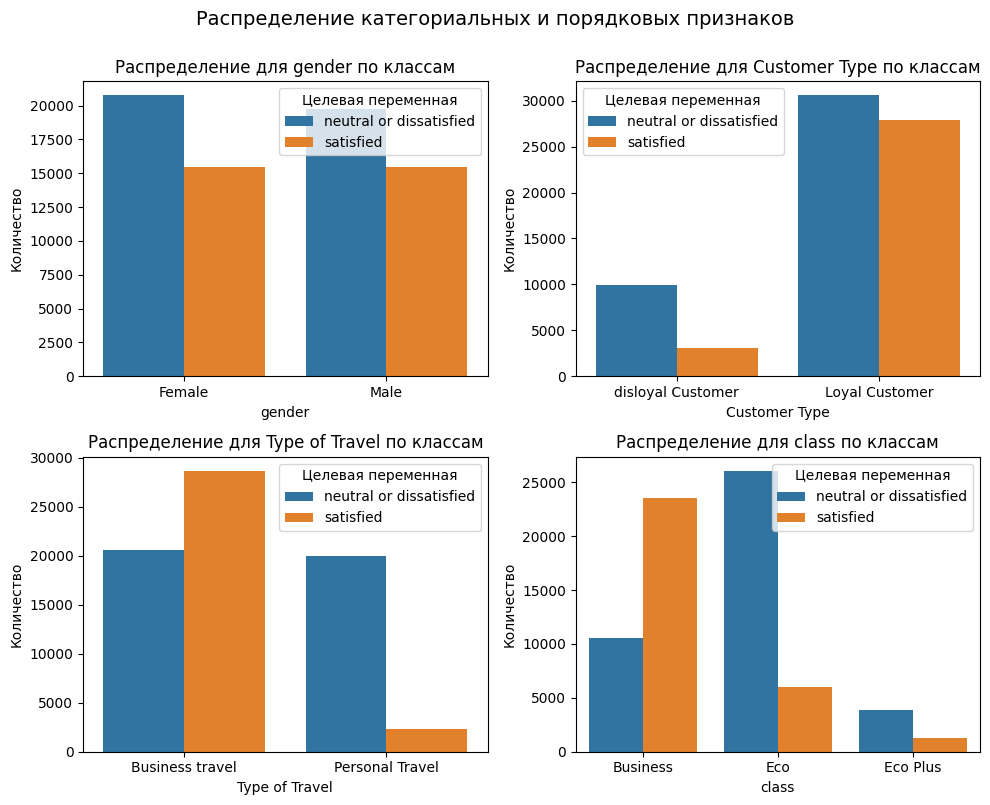

In [24]:
plot_ord_cat(categorical_cols, X_train, y_train, 2, 2, (10,8))

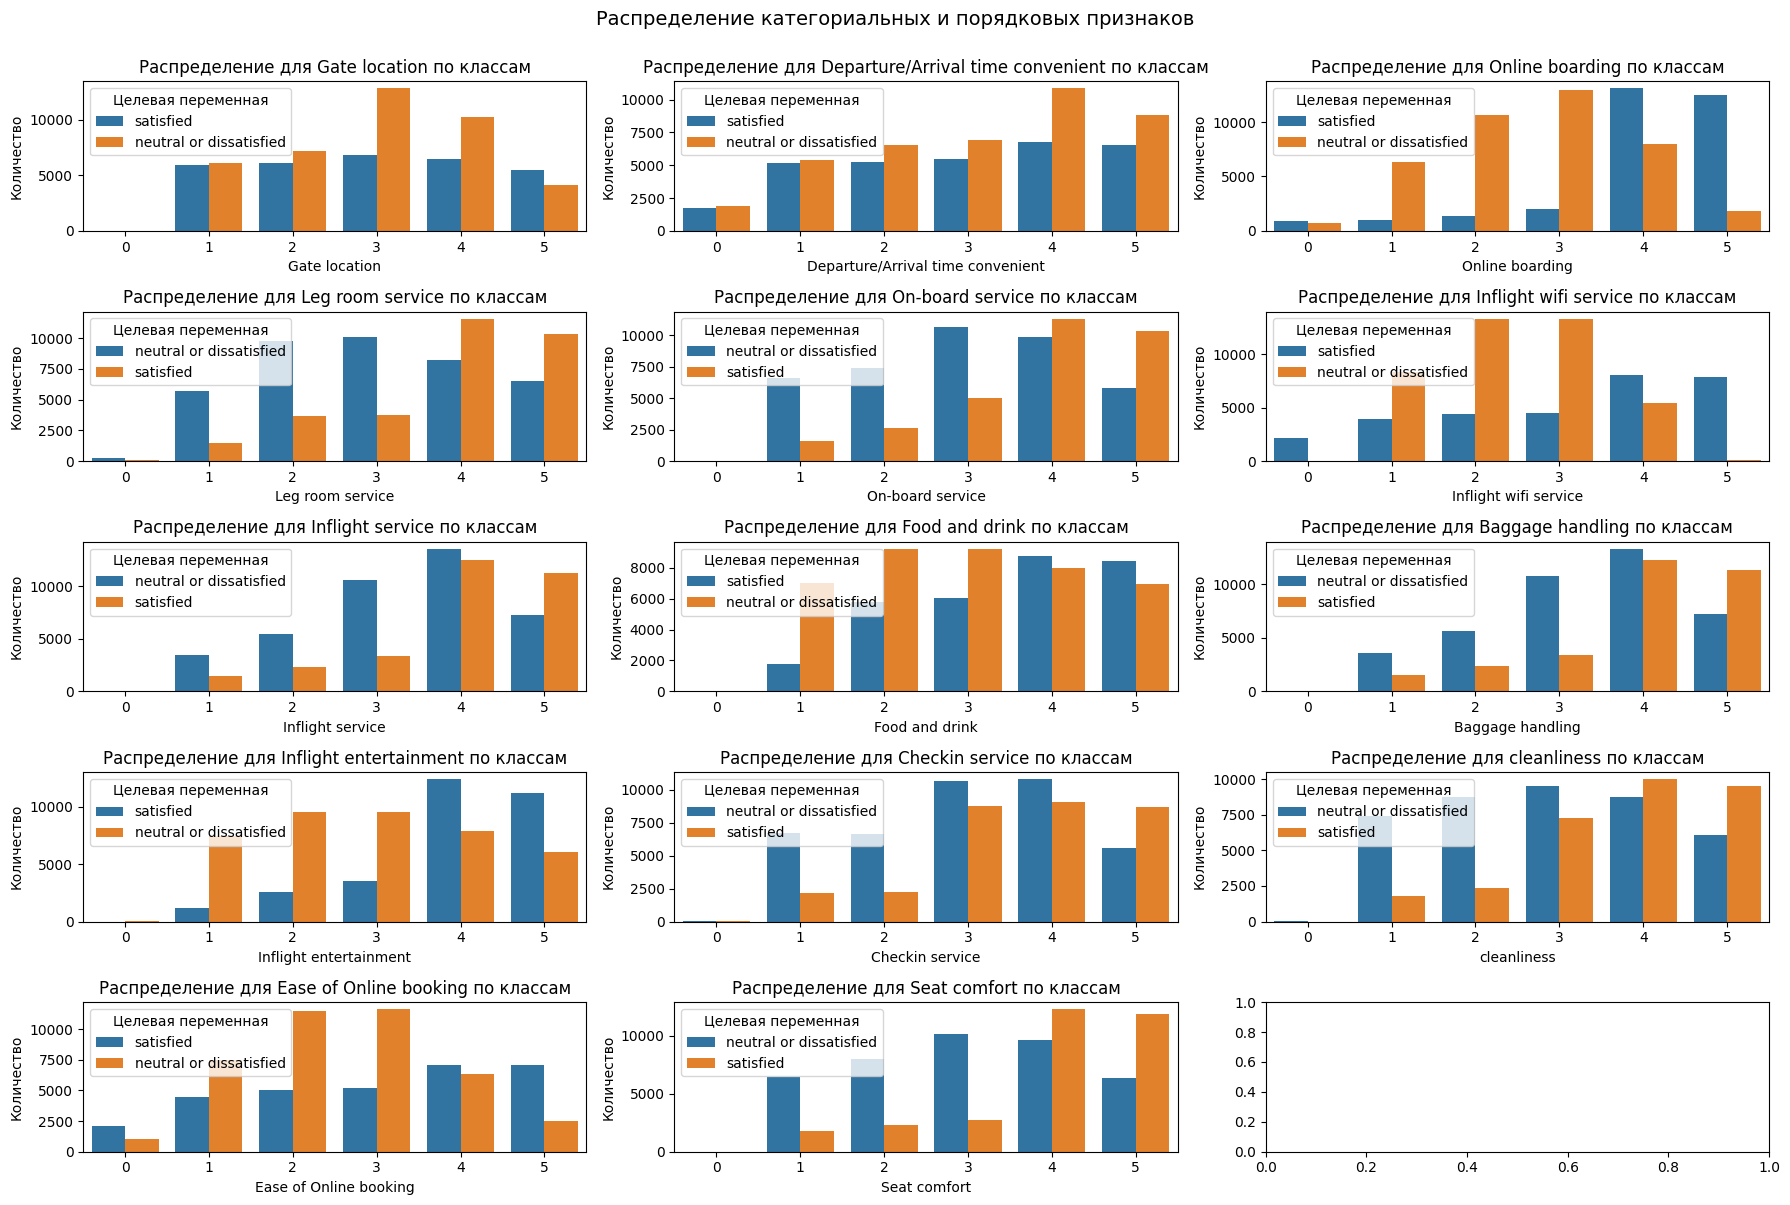

In [25]:
plot_ord_cat(ordinal_cols, X_train, y_train, 5, 3, (18, 12))

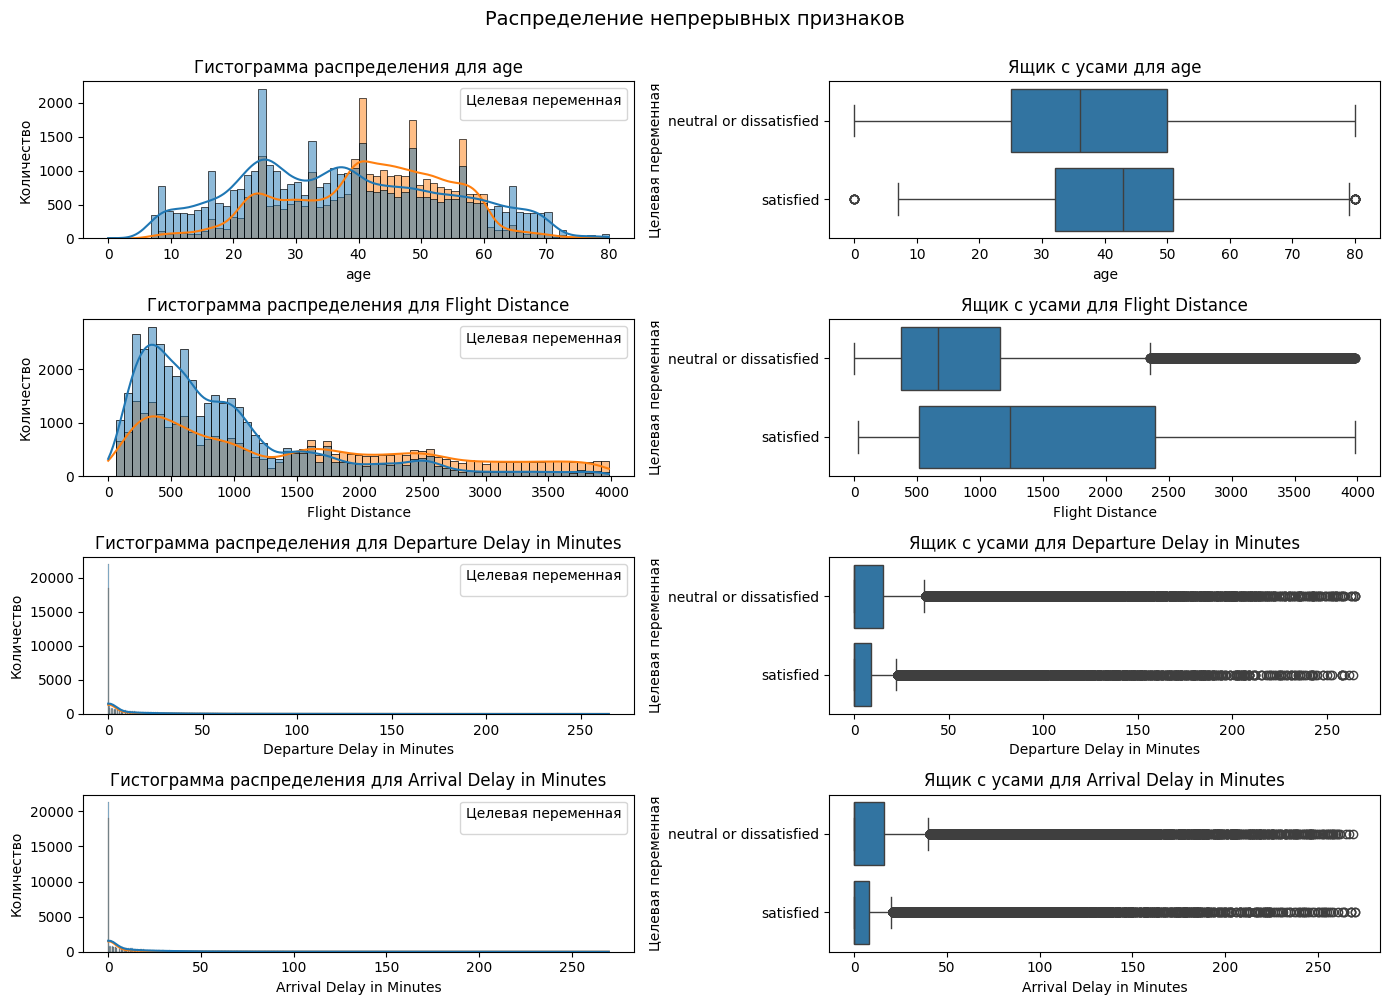

In [26]:
plot_continuous(continuous_cols, X_train, y_train)

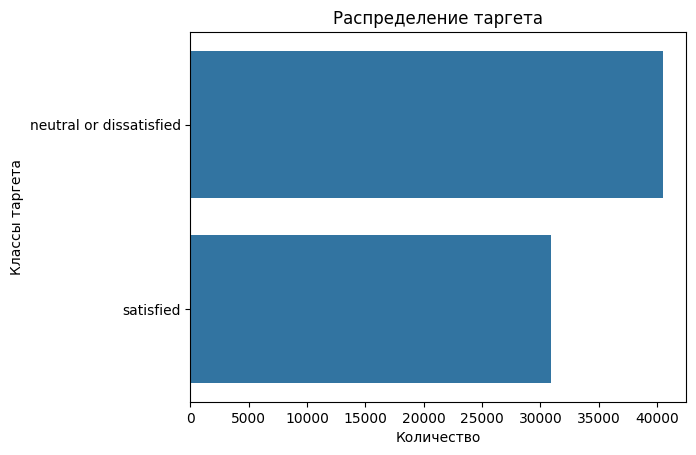

In [27]:
# Распределение таргета
sns.countplot(data=y_train)
plt.title('Распределение таргета')
plt.xlabel('Количество')
plt.ylabel('Классы таргета')
plt.show()

`Все графики построены!`

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

`Выводы`

1. Распределение категориальных признаков:

* Признаки Customer Type, Type of Travel, и class распределены неравномерно, особенно между лояльными/нелояльными клиентами и типами путешествий. Лояльные клиенты и бизнес-путешественники чаще удовлетворены, в то время как личные поездки и эконом-класс чаще связаны с неудовлетворённостью.
* Распределение по gender выглядит относительно сбалансированным.

2. Сбалансированность классов целевой переменной:

* Классы satisfied и neutral or dissatisfied несбалансированы: доля неудовлетворённых клиентов больше, чем удовлетворённых.

3. Континуальные признаки:

* Признаки age, Flight Distance, Departure Delay in Minutes, и Arrival Delay in Minutes имеют асимметричные распределения. Например, возраст и расстояние в основном сосредоточены в среднем диапазоне, а задержки имеют сильный правый хвост, указывая на наличие редких длительных задержек.

4. Выбросы:

* В континуальных признаках наблюдаются выбросы, особенно в задержках рейсов (Departure Delay in Minutes и Arrival Delay in Minutes). Это подтверждается наличием длинных "усов" в боксплотах.


### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

In [28]:
# Ваш код ниже


### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [29]:
# Будем использовать log(1+x), чтобы избежать бесконечностей
for c in ['Departure Delay in Minutes', 'Arrival Delay in Minutes']:
    X_train[c] = np.log1p(X_train[c])

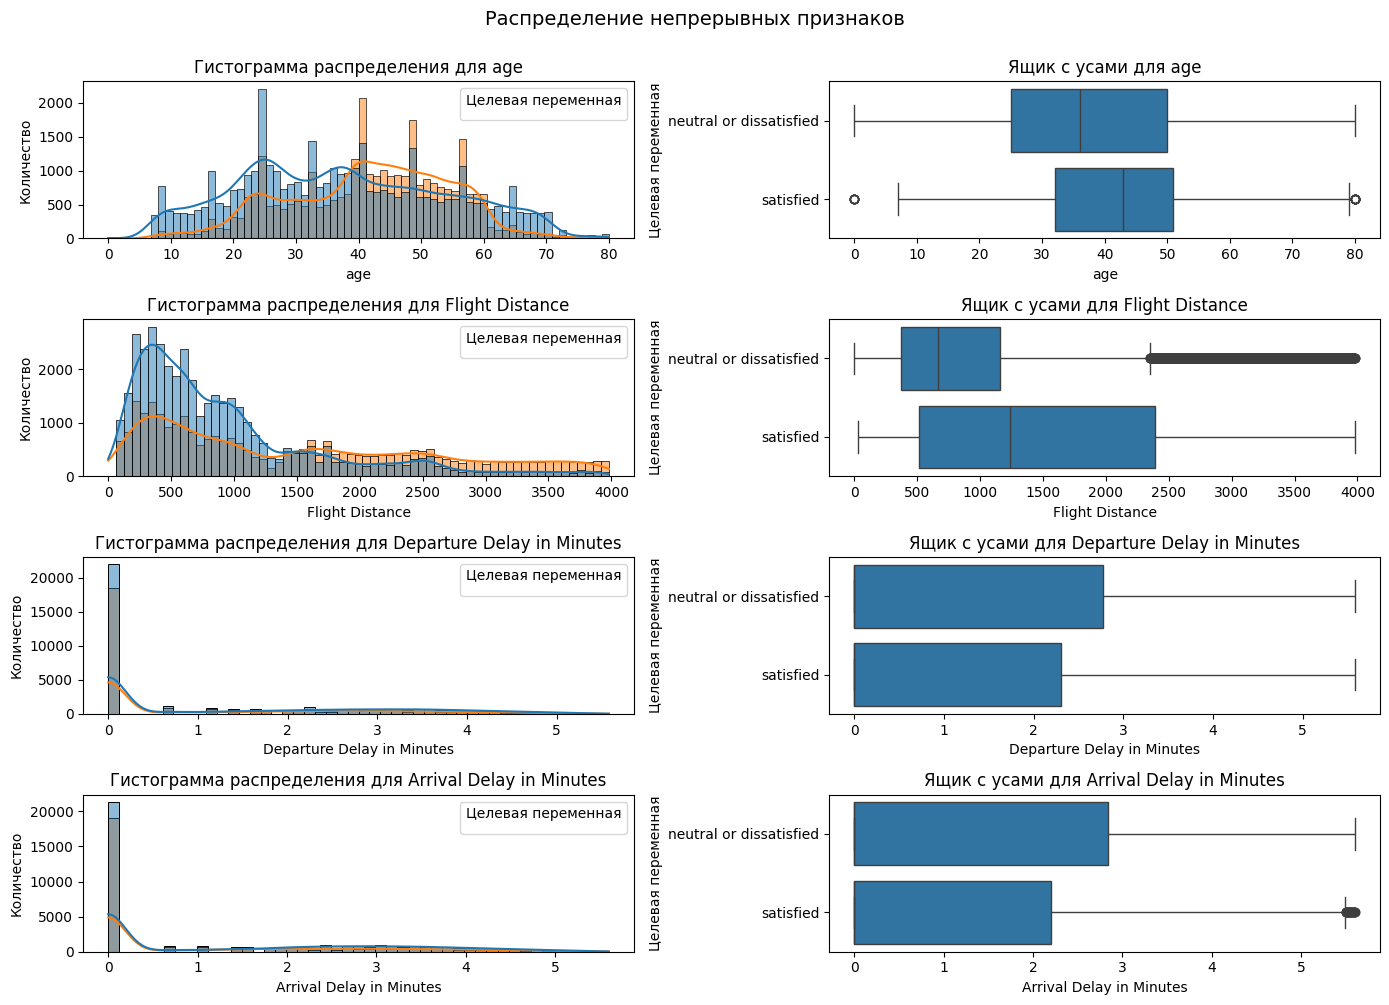

In [30]:
plot_continuous(continuous_cols, X_train, y_train)

`Картина с выбросами улучшилась, последние 2 графика стали более читаемыми`

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

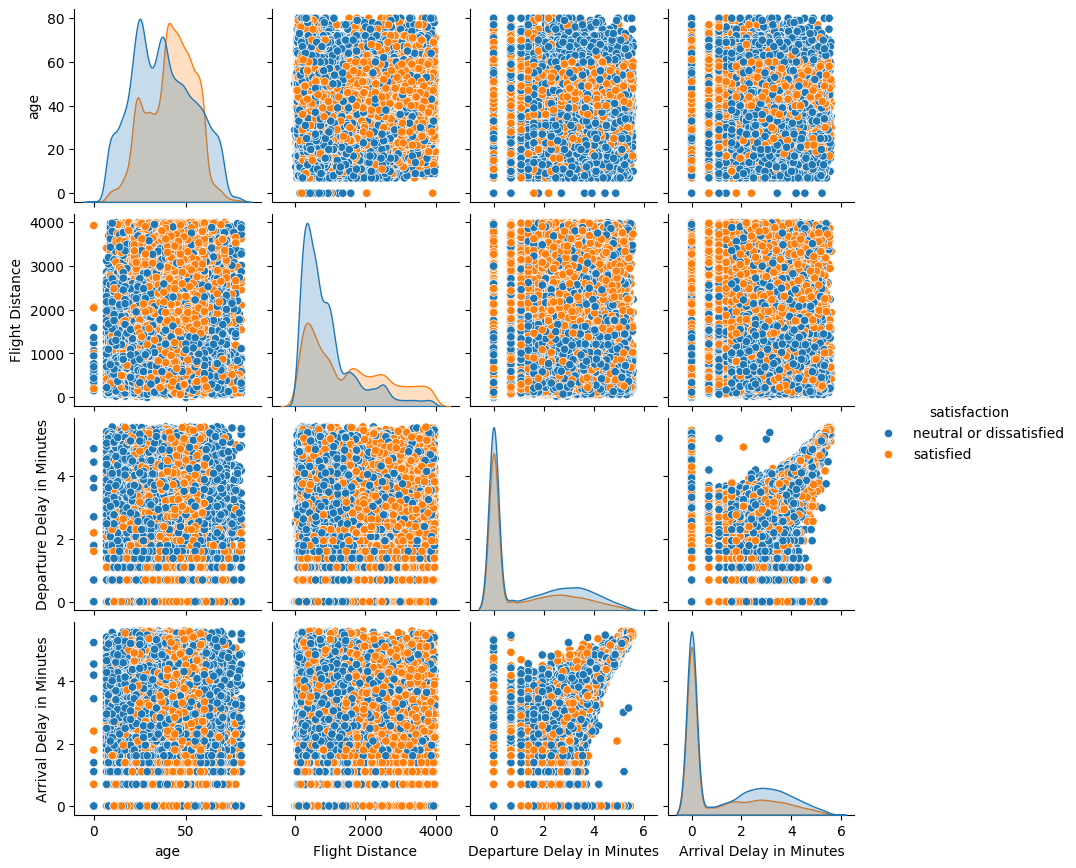

In [31]:
# Объединение данных для построения графика
pp_data = X_train[continuous_cols].copy()
pp_data['satisfaction'] = y_train

sns.pairplot(pp_data, hue="satisfaction", diag_kind="kde", height=2.2)
plt.show()

`Выводы`

1. Возраст и удовлетворенность:

* Удовлетворенные пассажиры чаще встречаются в старших возрастных группах, в то время как нейтральные или неудовлетворенные более равномерно распределены по возрасту.

2. Расстояние полета:

* Пассажиры, совершающие дальние перелеты, чаще удовлетворены. На коротких перелетах доля нейтральных или неудовлетворенных выше.

3. Задержки при отправлении и прибытии:

* Увеличение задержек (как при отправлении, так и при прибытии) связано с ростом доли неудовлетворенных пассажиров.
* Графики показывают, что при больших задержках почти нет удовлетворенных пассажиров.

3. Корреляция между задержками:

* Задержки при отправлении и прибытии имеют очевидную положительную корреляцию. Это означает, что задержка на вылет часто приводит к задержке на прибытие.

4. Общее распределение:

* Графики также показывают, что большинство наблюдений (пассажиров) имеют небольшие задержки или их отсутствие, а основные группы пассажиров — на рейсах средней или малой дальности.

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [11]:
# Маппинг таргетов
y_train = y_train.map({'satisfied': 1, 'neutral or dissatisfied': 0})
y_val = y_val.map({'satisfied': 1, 'neutral or dissatisfied': 0})

# OHE
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
X_train_ohe = ohe.fit_transform(X_train[categorical_cols])
X_val_ohe = ohe.transform(X_val[categorical_cols])

In [12]:
# Забираем названия признаков и создаём итоговые датафреймы признаков
feature_names = ohe.get_feature_names_out()
X_train_ohe = pd.DataFrame(X_train_ohe, columns=feature_names)
X_val_ohe = pd.DataFrame(X_val_ohe, columns=feature_names)

# Создаём ohe датасеты
X_train_ohe = X_train_ohe.join(X_train.select_dtypes(exclude='object').reset_index())
X_val_ohe = X_val_ohe.join(X_val.select_dtypes(exclude='object').reset_index())

# Сбрасываем индекс у таргетов после джоина признаков
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [13]:
# Обучаем дерево
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_ohe, y_train)
dt_pred = dt.predict(X_val_ohe)

# accuracy для валидационной выборки
accuracy_score(y_val, dt_pred)

0.9424509803921569

`accuracy score для валидационной выборки близок к 1, что очень неплохо для дерева решений с параметрами по умолчанию`

## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [35]:
# Считаем ошибку, смещение и разброс
error_dt, bias_dt, var_dt = bias_variance_decomp(dt, X_train_ohe.values, y_train.values,  
                                                 X_val_ohe.values, y_val.values,
                                                 loss='0-1_loss', 
                                                 random_seed=42)
error_dt, bias_dt, var_dt

(0.08603921568627451, 0.045098039215686274, 0.0702372549019608)

`Ошибка равна 0.086, смещение 0.05 и разброс 0.07, на основе чего можно сделать вывод, что модель неплохо сбалансирована (при этом обучена с дефолтными гиперпараметрами)`

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [36]:
print(dt.get_depth())
dt.get_n_leaves()

34


2003

`Глубина равна 34 (это большое значение, что может указыать на переобучение модели), а количество листьев 2003 (что также является большим значением и может указывать на переобучение)`

### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

In [48]:
# Забираем названия признаков и преобразуем в формат таблицы для графика
feats_imp = pd.DataFrame.from_dict({'feature': X_train_ohe.columns, 'importance': dt.feature_importances_})
feats_imp[['feature_original', 'class']] = feats_imp['feature'].str.split('_', expand=True)
feats_imp.loc[feats_imp['class'].isna(), 'class'] = feats_imp['feature_original']

# Сразу сделаем группировку, чтобы корректно отсортировать признаки по важности
feats_imp_group = (feats_imp.groupby('class', as_index=False)['importance'].mean()
                   .sort_values(by='importance', ascending=False))
feats_imp_group.head()

class  importance
17         Online boarding    0.361325
13   Inflight wifi service    0.178364
18         Personal Travel    0.150728
11  Inflight entertainment    0.043123
22       disloyal Customer    0.032324

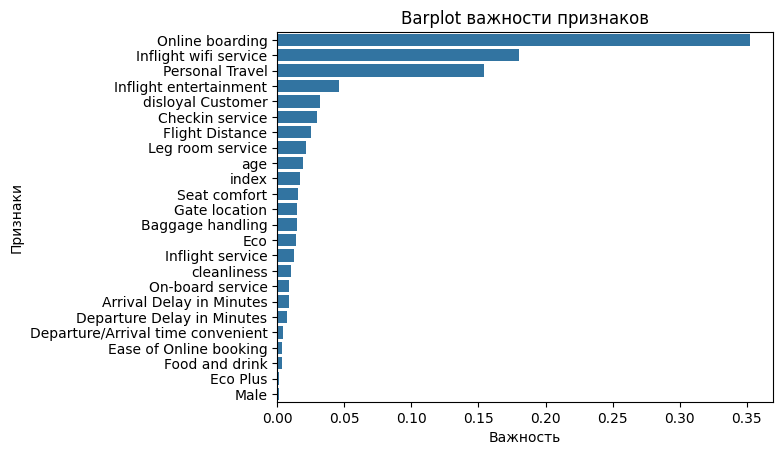

In [38]:
sns.barplot(feats_imp_group, x='importance', y='class', errorbar=None)
plt.ylabel("Признаки")
plt.xlabel("Важность")
plt.title("Barplot важности признаков")
plt.show()

`Выводы`
* Наиболее значимым признаком оказался Online boarding (0.36), вторым самым значимым признаком оказался Inflight wifi service (0.18)
* Наименее значимыми признаками оказались Eco Plus (Класс полёта) и Male (мужской пол), их важность близка к нулю

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [39]:
# Задаём матрицу объект-признак
X_train_2 = X_train_ohe[['Online boarding', 'Inflight wifi service']]

dt_2 = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_2.fit(X_train_2, y_train)
dt_2_pred = dt_2.predict(X_val_ohe[['Online boarding', 'Inflight wifi service']])

accuracy_score(y_val, dt_2_pred)

0.8248366013071895

In [40]:
print(dt_2.get_depth())
dt_2.get_n_leaves()

5


20

`accuracy_score снизился до 0.82, но при этом дерево стал значительно проще, если судить по глубине и количеству листьев`

### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

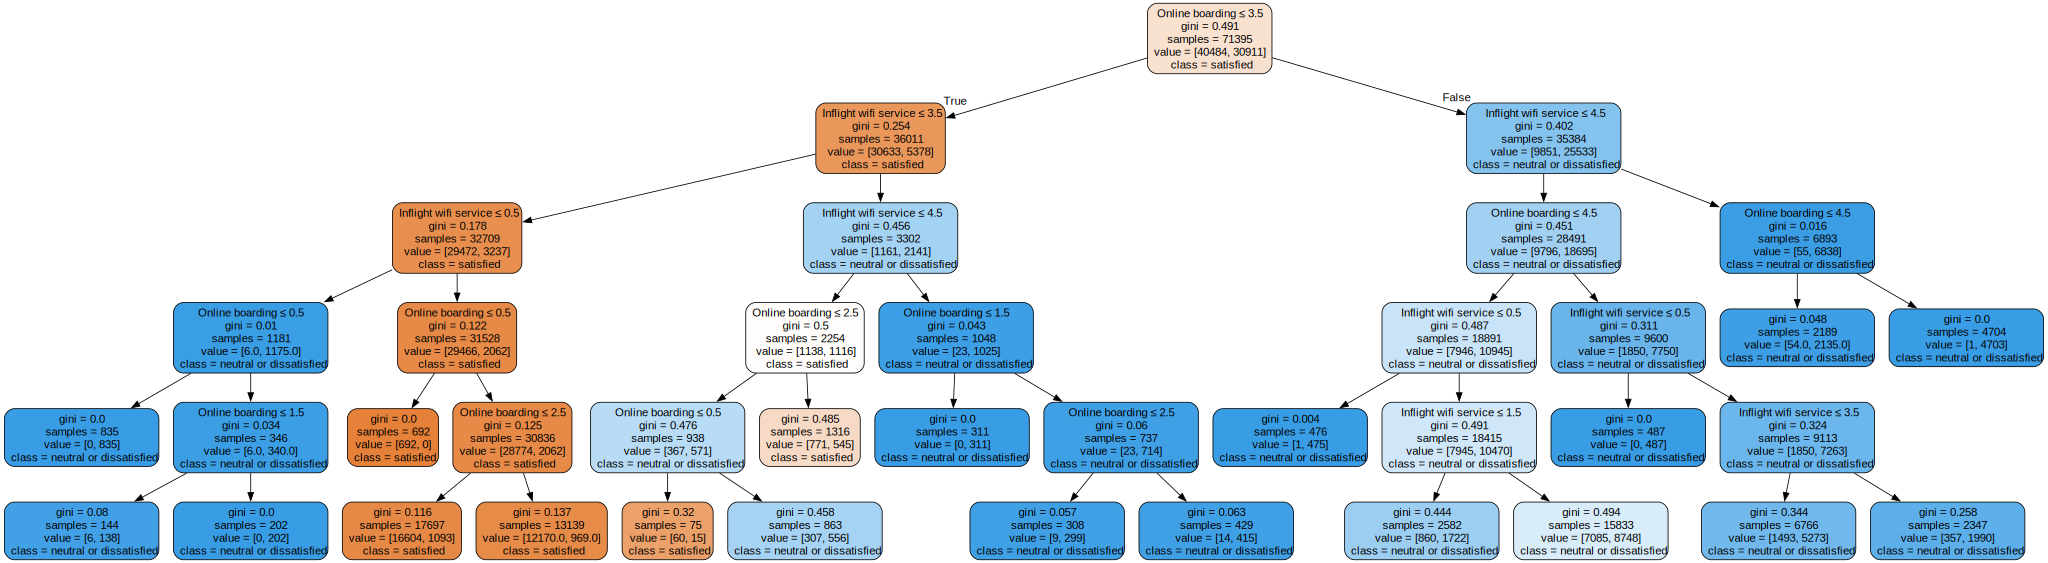

In [41]:
# Рендеринг черех graphviz
tree_data = export_graphviz(
    dt_2,
    out_file=None,
    feature_names=X_train_2.columns.tolist(),
    class_names=df_train['satisfaction'].unique().tolist(),
    filled=True,
    rounded=True,
    special_characters=True)

graph = Source(tree_data)
graph

`Источников не нашёл по теме, но могу предположить, что предикаты кратны 1/2 потому что это помогает модели наиболее точно разделить данные на выборки в листьях`

*Гуглить — можно, но помните о культуре цитирования.*

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

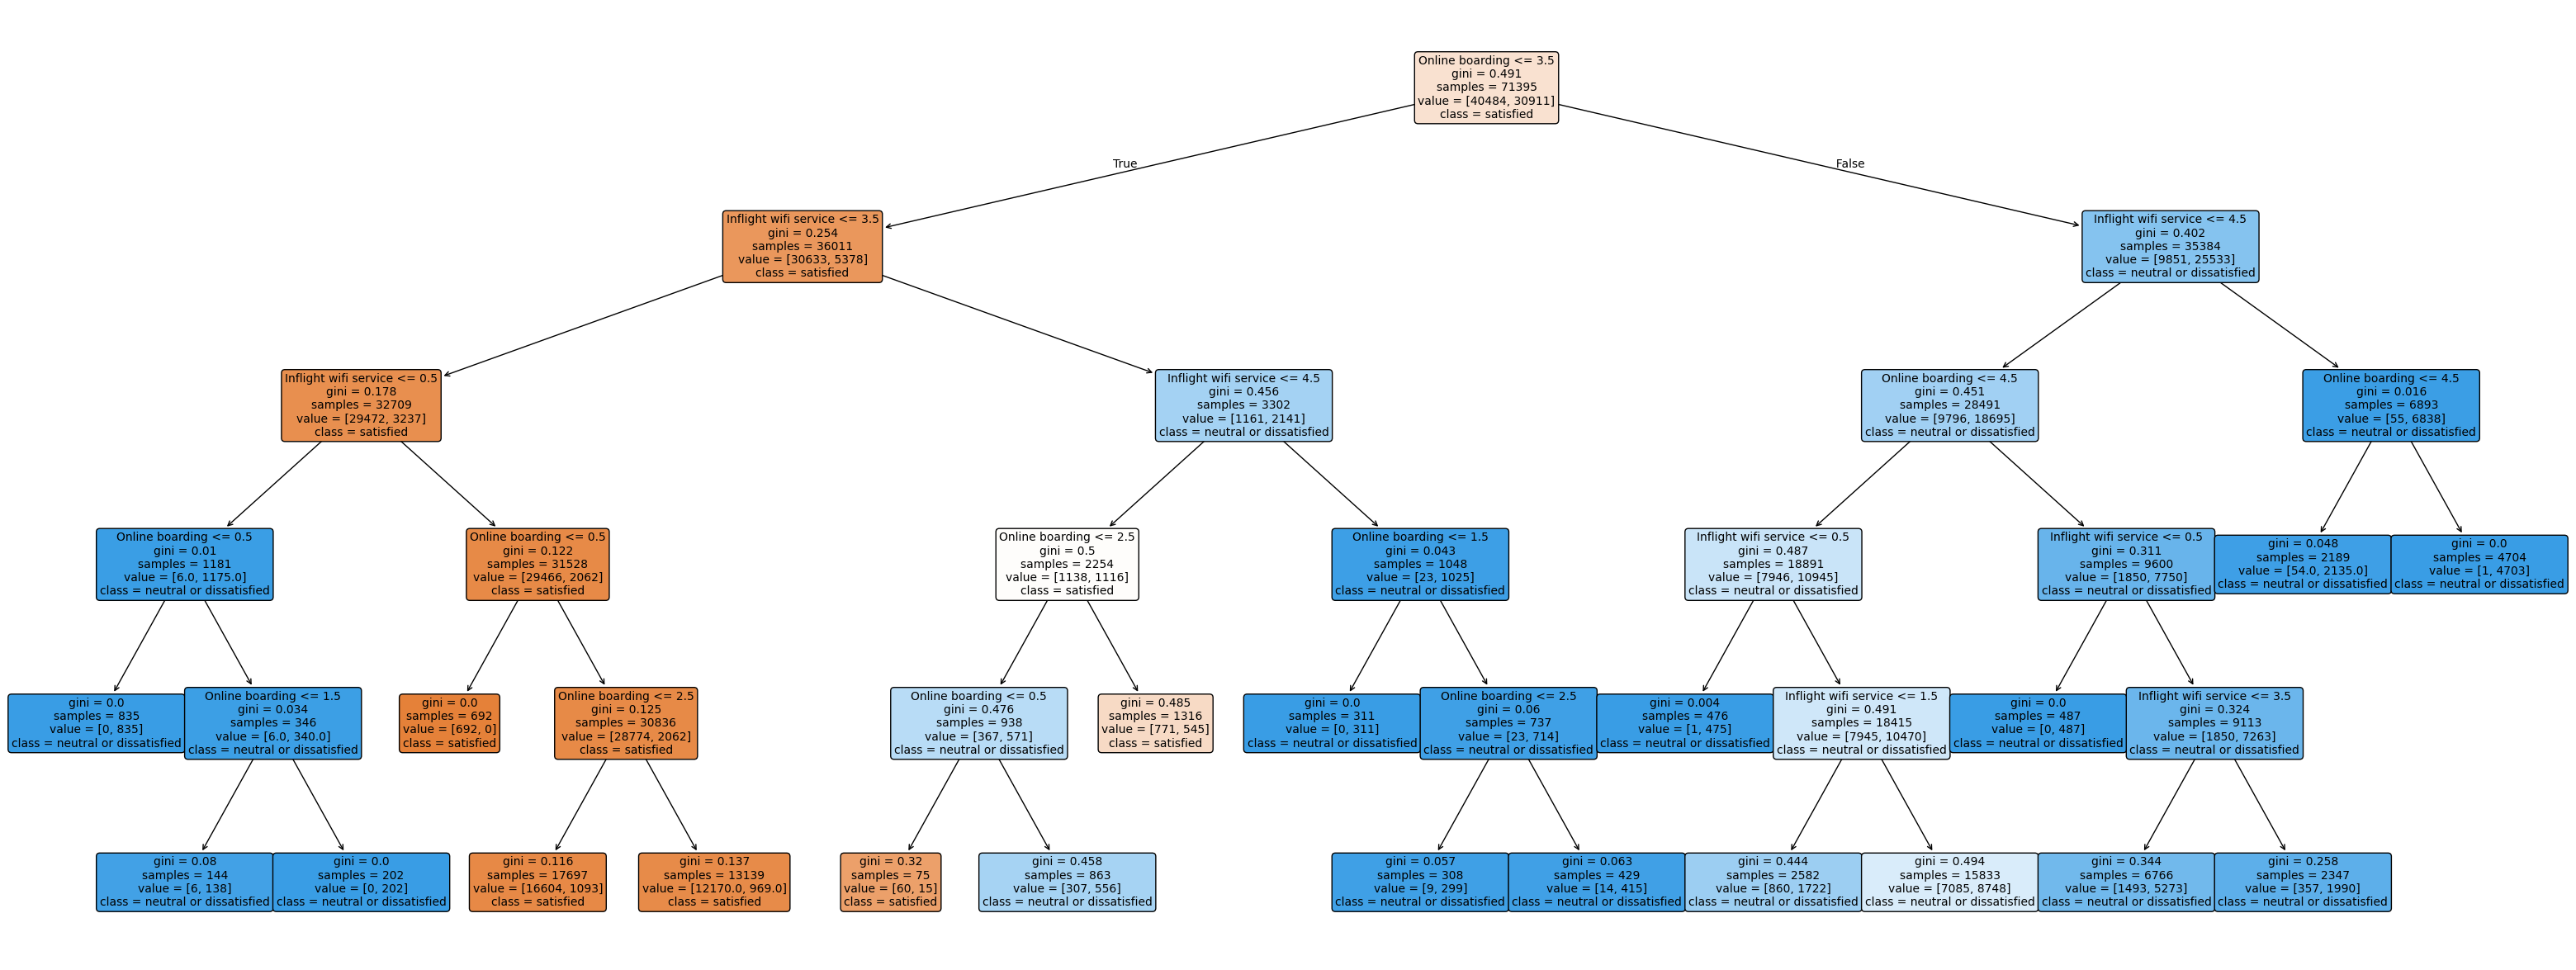

In [42]:
plt.figure(figsize=(40, 15))
plot_tree(
    dt_2,
    feature_names=X_train_2.columns.tolist(),
    class_names=df_train['satisfaction'].unique().tolist(),
    filled=True,
    rounded=True,
    fontsize=10)

plt.show()

`Дерево получилось несимметричным, что может указывать на его склонность к переобучению (что мы заметили, когда строили дерево по всем признакам), с другой стороны выборки разделились наиболее эффективно для случая 2 наиболее важных признаков и глубины 5, в целом кажется что дерево хорошо настроено для нашей задачи`

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

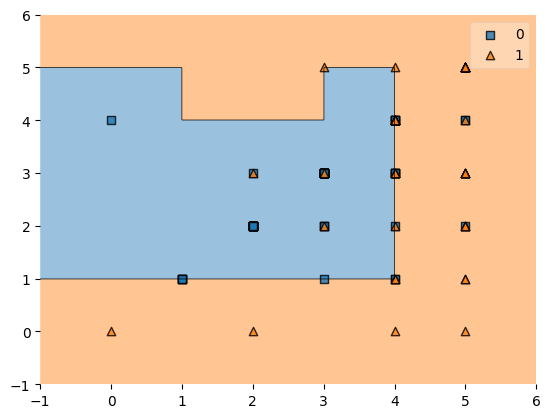

In [43]:
plot_decision_regions(clf=dt_2, X=np.array(X_train_2.iloc[:100, :]), y=np.array(y_train[:100]))
plt.show()

`По графику для первых 100 объектов обучающей выборки можно заметить, что многие объекты классифицированы верно, но при этом внутри и синей, и оранжевой областей имеются ошибки`

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

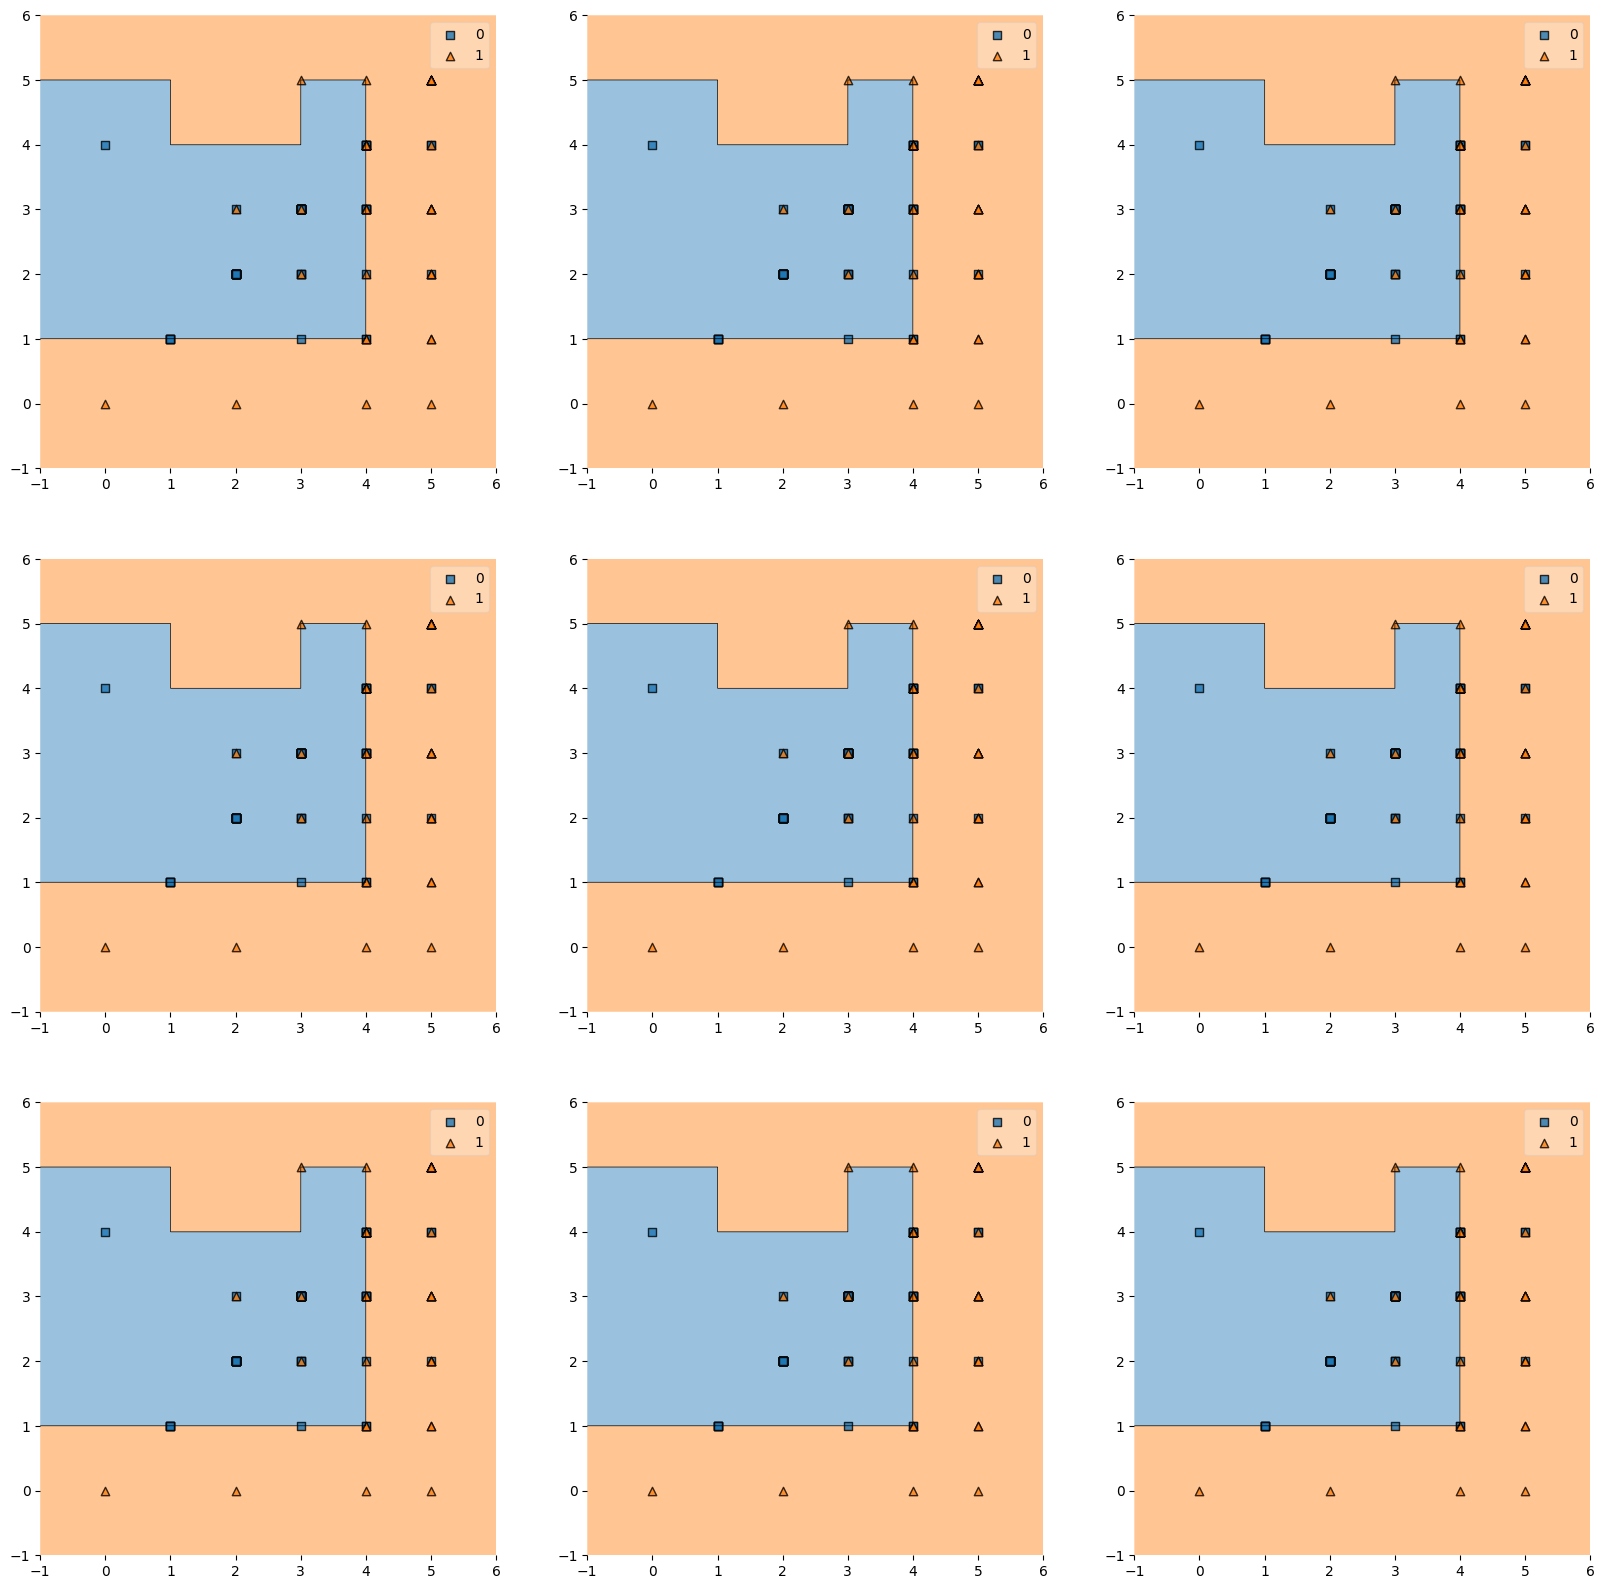

In [44]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_2.index, size=X_train_2.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_2.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_2.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

`В моём случае граница не двигалась)`

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [45]:
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_ohe, y_train)
    y_predicted_train = DT.predict(X_train_ohe)
    y_predicted_val = DT.predict(X_val_ohe)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

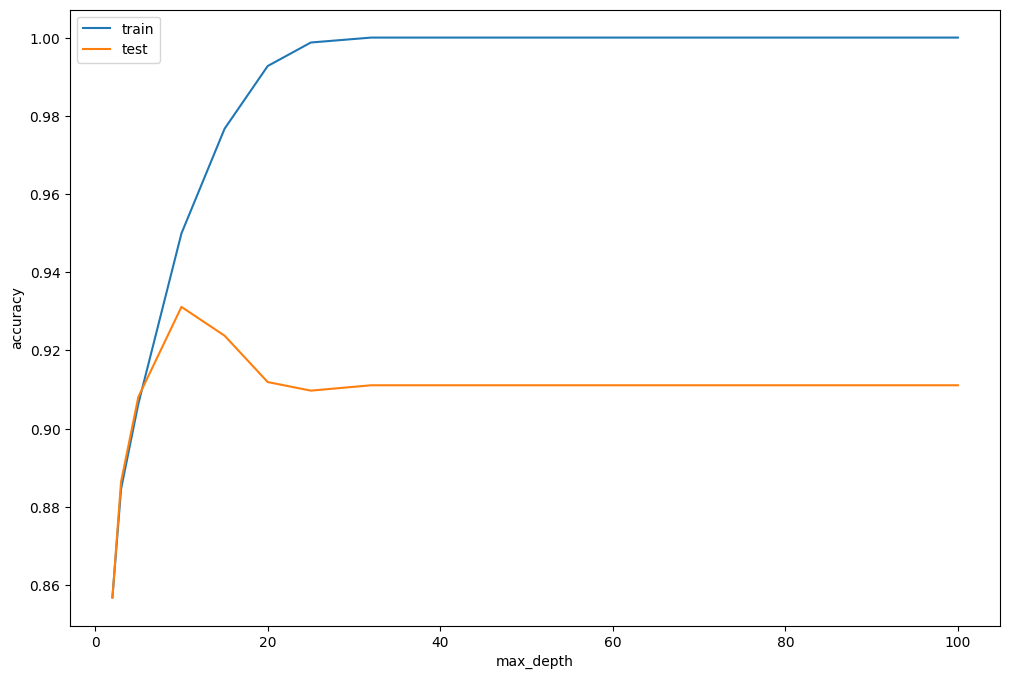

In [46]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [47]:
# Воспользуемся Optuna для поиска оптимальных гиперпараметров
def objective_tree(trial):    
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])

    # Задаём модель
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf = min_samples_leaf,
        criterion=criterion,
        random_state=42)

    score = cross_val_score(model, X_train_ohe, y_train, cv=3, scoring="accuracy",  n_jobs=-2).mean()
    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective_tree, n_trials=50)

[I 2025-01-29 14:15:37,375] A new study created in memory with name: no-name-096f0f6c-19c9-4b87-8cfd-f50fc04535df
[I 2025-01-29 14:15:38,918] Trial 0 finished with value: 0.9323342303969504 and parameters: {'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 0 with value: 0.9323342303969504.
[I 2025-01-29 14:15:40,055] Trial 1 finished with value: 0.9457384786312714 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 1 with value: 0.9457384786312714.
[I 2025-01-29 14:15:41,148] Trial 2 finished with value: 0.9357238168368663 and parameters: {'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 1 with value: 0.9457384786312714.
[I 2025-01-29 14:15:42,292] Trial 3 finished with value: 0.9455984067186455 and parameters: {'max_depth': 11, 'min_samples_split': 16, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 1

In [48]:
# Результаты
print("Лучшие параметры:", study.best_params)
print("Лучший результат на train:", study.best_value)

# Обучение модели с лучшими параметрами
best_params = study.best_params
best_model = DecisionTreeClassifier(**best_params)
best_model.fit(X_train_ohe, y_train)

# Оценка на валидационной выборке
y_pred = best_model.predict(X_val_ohe)
print("Лучший результат на val:", accuracy_score(y_val, y_pred))

Лучшие параметры: {'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 17, 'criterion': 'entropy'}
Лучший результат на train: 0.9475593393387532
Лучший результат на val: 0.9518954248366013


`Оптимальные гиперпараметры для решающего дерева удалось подобрать через Optuna, accuracy на валидационной выборке выросло с 0.91 до 0.95`

### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [49]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [70]:
# Обучаем случайный лес
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_ohe, y_train)
rf_pred = rf.predict(X_val_ohe)
accuracy_score(y_val, rf_pred)

0.961078431372549

`При дефолтных параметрах accuracy выше для случайного леса (0.961), чем accuracy для дерева решений с подобранными гиперпараметрами (0.953)`

### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

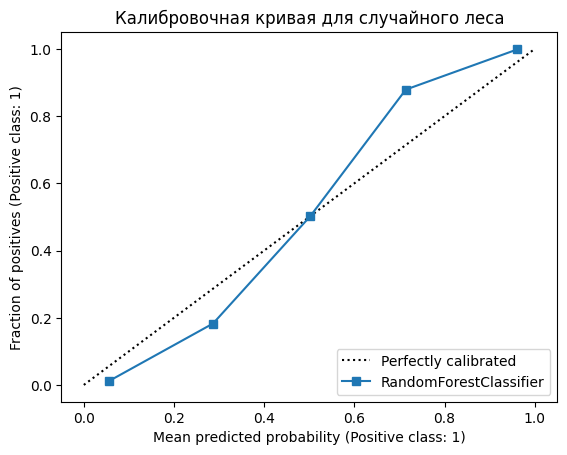

In [51]:
# Строим калибровочную кривую для случайного леса
cd = CalibrationDisplay.from_estimator(rf, X_val_ohe, y_val, strategy='uniform')
plt.title("Калибровочная кривая для случайного леса")
plt.show()

`По моей кривой получилось, что идёт недооценка низких вероятностей и переоценка высоких, всё равно будем калибровать`

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?

```
Дерево решений не очень хорошо предсказывает вероятности, есть несколько причин почему это так:
```

* Дерево делит пространство признаков на непересекающиеся области, при этом каждому листу даётся определенный класс, в результате чего отсутствует плавное распределение вероятностей.
* Деревья склонны к переобучению (запоминают обучающие данные, а не находят реальные зависимости в них). В итоге мы получаем вероятности, которы искусственно приближено к 1 или 0.
* Деревья чувствительны к дисбалансу классов, если одного из классов больше, то для него вероятности могут быть завышены.

### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

In [18]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_ohe, y_train)

# Оценка на валидационной выборке
y_pred = lr.predict(X_val_ohe)
print("Лучший результат на val:", accuracy_score(y_val, y_pred))

Лучший результат на val: 0.685326797385621


`Значение accuracy для логистической регрессии (0.69) значительно ниже, чем для случайного леса и дерева решений (>0.9)`

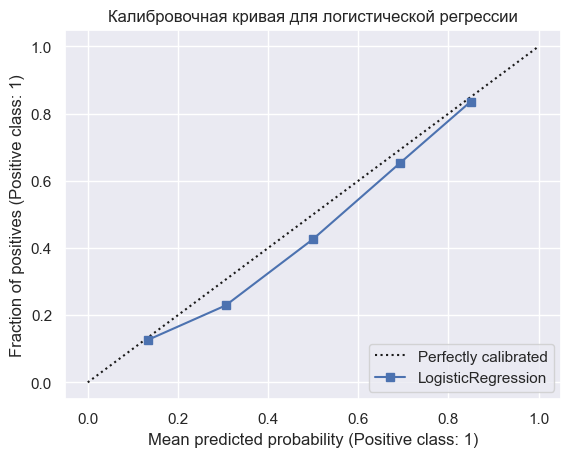

In [19]:
# Строим калибровочную кривую для логистической регрессии
cd = CalibrationDisplay.from_estimator(lr, X_val_ohe, y_val, strategy='uniform')
plt.title("Калибровочная кривая для логистической регрессии")
plt.show()

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?

In [20]:
# Покажем на примере brier score
y_pred_proba = lr.predict_proba(X_val_ohe)[:,1]
brier_score = brier_score_loss(y_val, y_pred_proba)
print(f"Brier Score: {brier_score:.4f}")

Brier Score: 0.2027


```
Метрика показывает то, насколько предсказанные вероятности близки к реальным, значение в 0.2 говорит, что модель предсказывает вероятности близкие к истинным (но не достаточно близкие)
```

### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

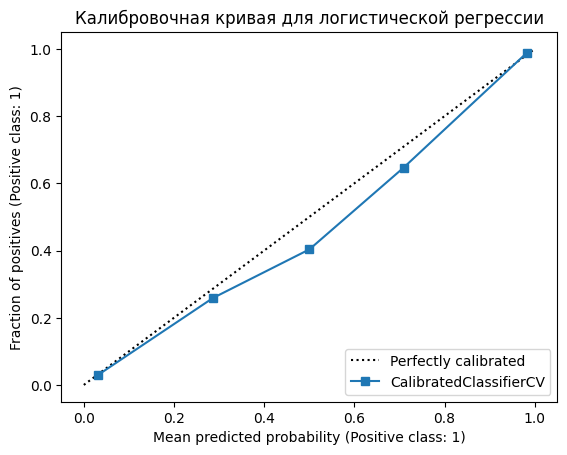

In [73]:
# Калибровка через логистическую регрессию
calibrated_rf_sigmoid = CalibratedClassifierCV(estimator=rf, method='sigmoid', cv=3)
calibrated_rf_sigmoid.fit(X_train_ohe, y_train)

# Строим калибровочную кривую откалиброванной модели
cd = CalibrationDisplay.from_estimator(calibrated_rf_sigmoid, X_val_ohe, y_val, strategy='uniform')
plt.title("Калибровочная кривая для логистической регрессии")
plt.show()

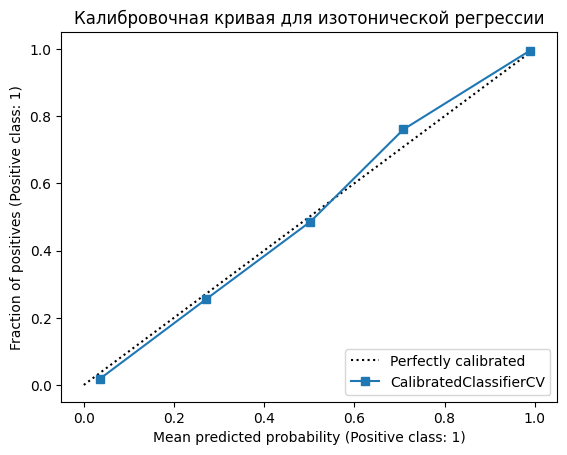

In [57]:
# Калибровка через изотоническую  регрессию
calibrated_rf_isotonic = CalibratedClassifierCV(estimator=rf, method='isotonic', cv=3)
calibrated_rf_isotonic.fit(X_train_ohe, y_train)

# Строим калибровочную кривую откалиброванной модели
cd = CalibrationDisplay.from_estimator(calibrated_rf_isotonic, X_val_ohe, y_val, strategy='uniform')
plt.title("Калибровочная кривая для изотонической регрессии")
plt.show()

`Калибровка через изотоническую регрессию показала более хороший результат`

### **Задание 28. (0.2 балла)**
- Опишите другие возможные подходы к калибровке вероятностей (со ссылками на источники)

```
Есть методы Histogram Binning и Platt Scaling Binning.
В первом предсказанные вероятности деляться на несколько интервалов и считается средняя истинная вероятность внутри каждой корзины, все объекты из корзины получают одинаковую (среднюю) вероятность.
Во втором методе данные делятся на квантили и калибруются в каждом из них.
```

https://ethen8181.github.io/machine-learning/model_selection/prob_calibration/prob_calibration.html

### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [64]:
# Считаем ошибку, смещение и разброс для случайного леса
error_rf, bias_rf, var_rf = bias_variance_decomp(rf, X_train_ohe.values, y_train.values,  
                                                 X_val_ohe.values, y_val.values,
                                                 loss='0-1_loss', 
                                                 random_seed=42)
error_rf, bias_rf, var_rf

(0.04102450980392156, 0.03934640522875817, 0.009545424836601308)


```
Для случайного леса ошибка стала меньше (0.041), смещение тоже снизилось (0.039), но и разброс стал меньше (0.009), в теории смещение должно было остаться на уровне отдельного дерева (0.005), а разброс значительно уменьшится (так и произошло)
```

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [65]:
# Считаем смещение и разброс для логрега
error_lr, bias_lr, var_lr = bias_variance_decomp(lr, X_train_ohe.values, y_train.values,  
                                                 X_val_ohe.values, y_val.values,
                                                 loss='0-1_loss', 
                                                 random_seed=42)
error_lr, bias_lr, var_lr

(0.2337799019607843, 0.23254901960784313, 0.024726633986928103)

`Ошибка (0.23), смещение (0.23) и разброс (0.02) для логистической регрессии выше чем для случайного леса и дерева решений. Это может объяснятся нелинейными зависимостями в данных, чувствительностью логистической регрессии к шумам и выбросам, а также тем, что для случайного леса по его сути смещение и разброс меньше чем для линейной модели (а значит и ошибка меньше)`

### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [69]:
# Укажем сетку гиперпараметров, которые будем искать
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 40],
    'min_samples_split': np.round(uniform(loc=2, scale=9).rvs(size=3)).astype(int)}

rf_r = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_r,
    param_distributions=params,
    n_iter=30,
    scoring='accuracy',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-2)

random_search.fit(X_train_ohe, y_train)
print("Лучшие параметры:", random_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Лучшие параметры: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 40}


In [70]:
# Оценка на валидационной выборке
rf_r = random_search.best_estimator_
y_pred = rf_r.predict(X_val_ohe)
print("Лучший результат на val:", accuracy_score(y_val, y_pred))

Лучший результат на val: 0.9615032679738562


`При дефолтных параметрах accuracy для случайного леса (0.961), что незначительно ниже, чем для модели с подобранными через RandomizedSearch параметрами (0.9615)`

## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [71]:
# замените X_train_enc на ваш трейн

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_ohe[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

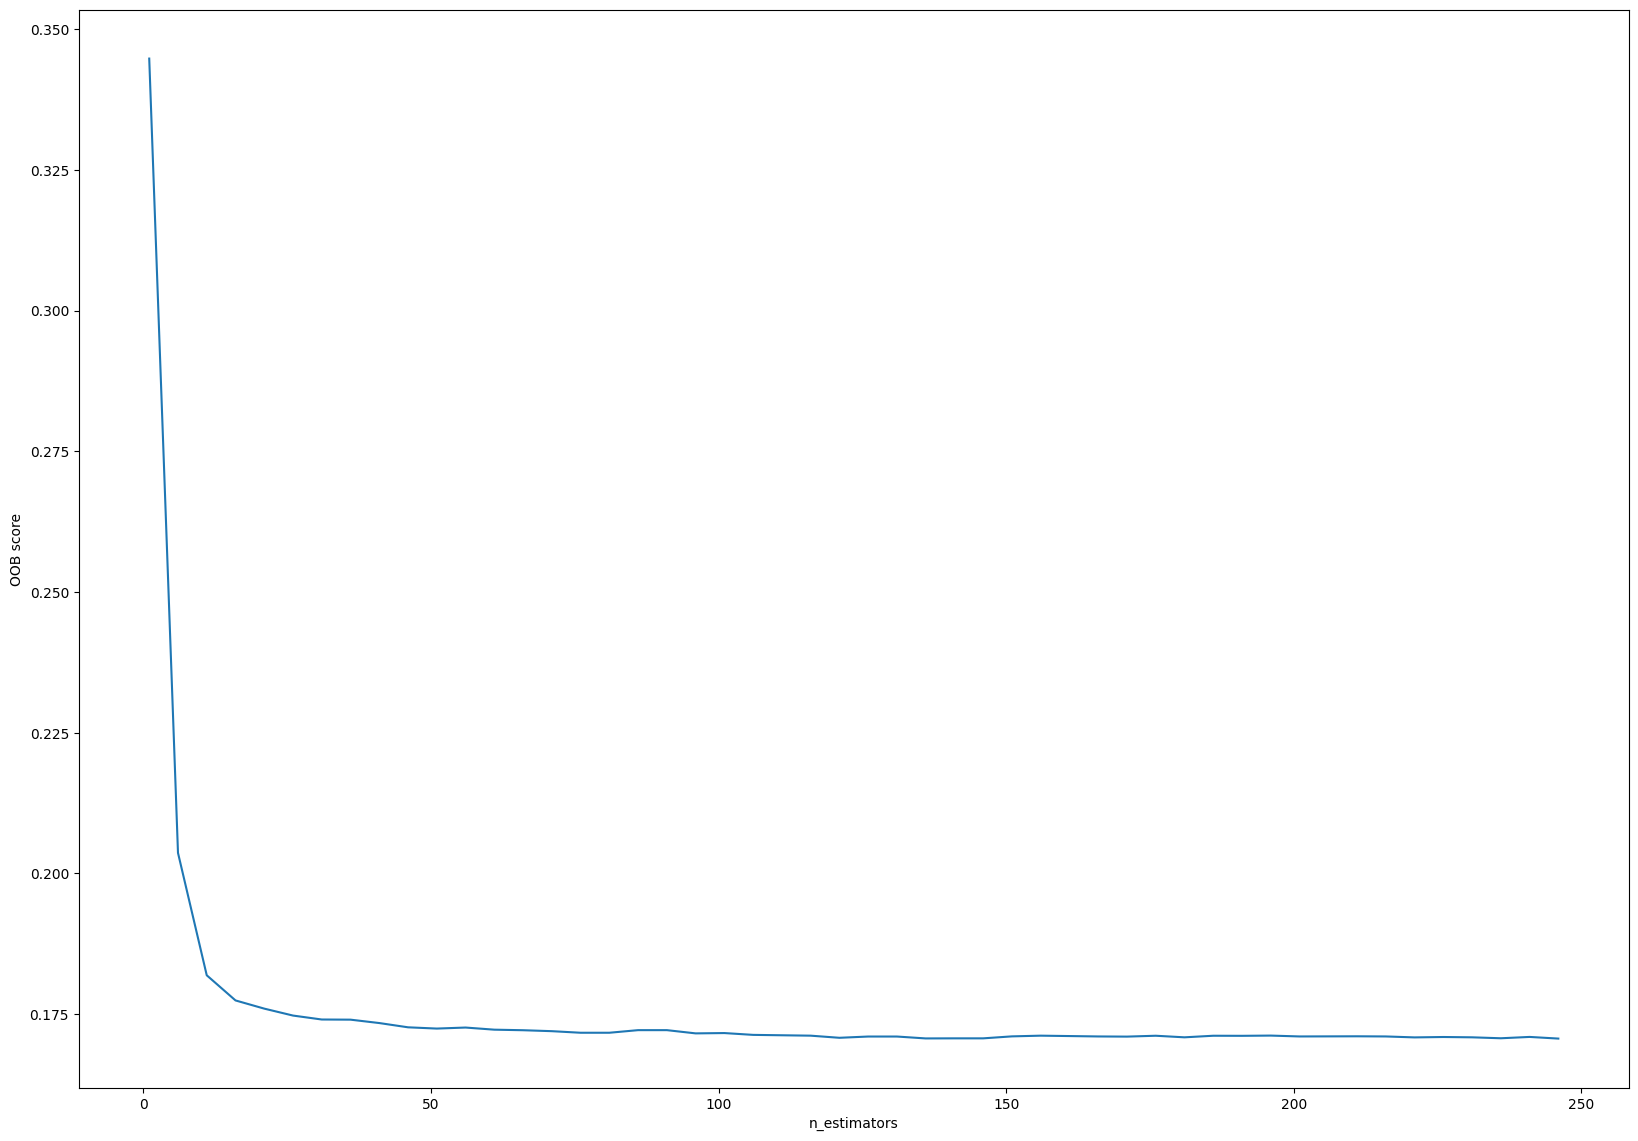

In [72]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


In [45]:
# Забираем названия признаков и преобразуем в формат таблицы для графика
feats_imp_rf = pd.DataFrame.from_dict({'feature': X_train_ohe.columns, 'importance': rf_r.feature_importances_})
feats_imp_rf[['feature_original', 'class']] = feats_imp_rf['feature'].str.split('_', expand=True)
feats_imp_rf.loc[feats_imp_rf['class'].isna(), 'class'] = feats_imp_rf['feature_original']

# Сразу сделаем группировку, чтобы корректно отсортировать признаки по важности
feats_imp_rf_group = (feats_imp_rf.groupby('class', as_index=False)['importance'].mean()
                   .sort_values(by='importance', ascending=False))
feats_imp_rf_group.head()

class  importance
17         Online boarding    0.170975
13   Inflight wifi service    0.135456
18         Personal Travel    0.110808
6                      Eco    0.070749
11  Inflight entertainment    0.059925

In [74]:
feats_imp_group.head()

class  importance
17         Online boarding    0.352033
13   Inflight wifi service    0.180080
18         Personal Travel    0.154332
11  Inflight entertainment    0.045931
22       disloyal Customer    0.032029

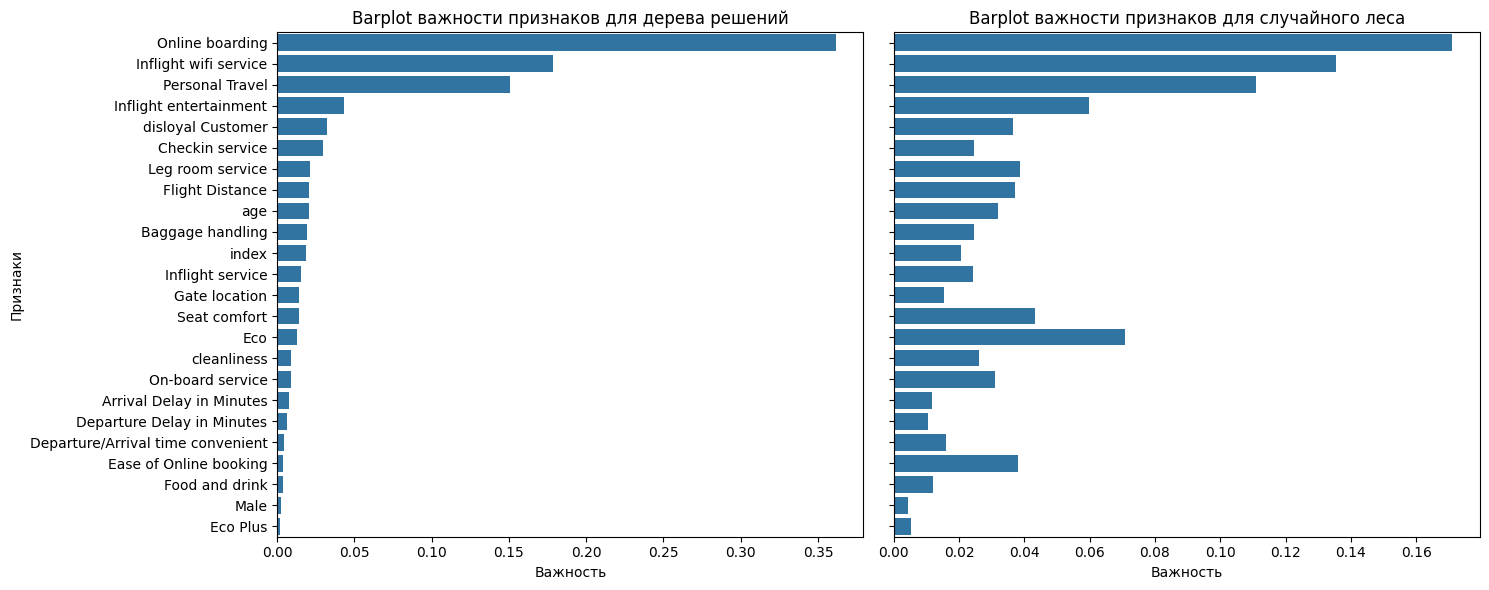

In [49]:
# Строим графики
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Barplot для дерева решений
sns.barplot(data=feats_imp_group, x='importance', y='class', errorbar=None, ax=axes[0])
axes[0].set_ylabel("Признаки")
axes[0].set_xlabel("Важность")
axes[0].set_title("Barplot важности признаков для дерева решений")

# Barplot для случайного леса
sns.barplot(data=feats_imp_rf_group, x='importance', y='class', errorbar=None, ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("Важность")
axes[1].set_title("Barplot важности признаков для случайного леса")

plt.tight_layout()
plt.show()

`2 наиболее важных признака для случайного леса точно такие же, как для дерева решений ("Online boarding", "Inflight wifi service"), но с меньшей важностью (0.17 и 0.14 соответственно), также можно заметить что дерево решений фокусируется на нескольких основных признаках, в то время как случайный лес более равномерно распределяет значимость между бОльшим количеством переменных`

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

In [76]:
with open('rf_random.pkl', 'wb') as f:
    pickle.dump(rf_r, f)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [47]:
random_sample = X_val_ohe.sample(n=1000, random_state=42)
explainer = shap.TreeExplainer(rf_r)
shap_values = explainer.shap_values(random_sample)

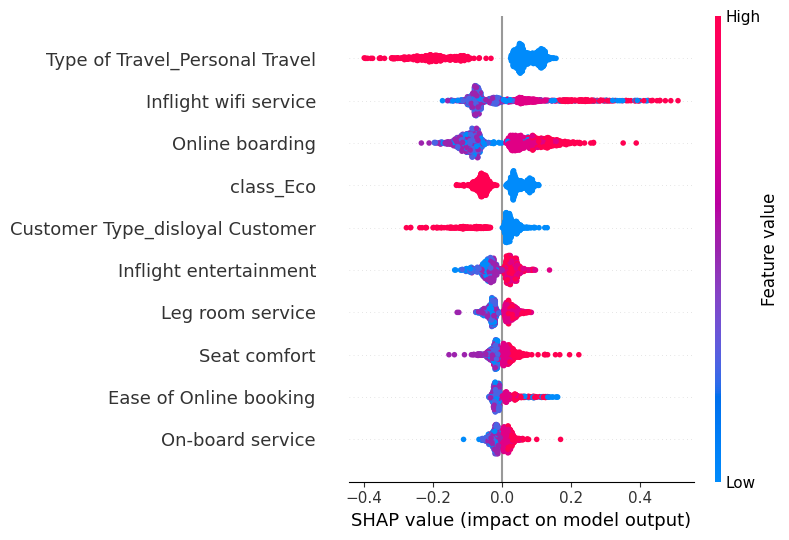

In [76]:
# Вклад признаков в пользу класса 1 (удовлетворенный клиент)
shap.summary_plot(shap_values[:, :, 1], random_sample, max_display=10)

`Выводы для 10 самых важных признаков`

1. Личные поездки (Personal Travel) вносят большой вклад в итоговый прогноз - увеличивают вероятность неудовлетворенности клиентов (много красных точек в отрицательной части, SHAP<0).
2. Качество wifi (Inflight wifi service) - увеличивает вероятность удовлетворенности клиента (много красных точек в положительной части, SHAP>0), низкая оценка (синие точки) приводят к неудовлетворенности клиента (но вклад не такой большой).
3. Возможность онлайн брони (Online boarding) - много красных точек в положительной части (SHAP>0), они также увеличивают вероятность удовлетворенности клиента, хотя наблюдается и достаточное количество синих точек в отрицательной части (SHAP<0).
4. Класс полёта (Eco) - у части выборки (красные точки) положительный вклад, у другой части отрицательный (синий), в целом распределения похожие.
5. Нелояльный тип клиента (Customer Type_disloyal Customer) - красные точки преобладают в отрицательной области, то есть увеличивается вероятность неудовлетворенности клиента (что довольно логично).
6. Сервисные признаки (Inflight entertainment, Leg room service, Seat comfort, Ease of Online booking, On-board service) - здесь наблюдается общий паттерн: красных точек больше в положительной части графика (SHAP>0), то есть чем лучше сервис, тем сильнее вклад в удовлетворенность.

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

В нём есть другие графики для интерпретации признаков моделей, например:
* SHAP Decision Plot (Как модель принимает решения) - как модель переходит от базового предсказания к итоговому
* SHAP Waterfall Plot (Пошаговое объяснение предсказания) - разбиение вклада признаков в итоговое предсказание
* SHAP Interaction Values (Взаимодействие признаков) - взаимодействие двух признаков друг с другом

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [65]:
# Важность признаков для одного прогноза
explainer = lime.lime_tabular.LimeTabularExplainer(X_val_ohe.values, feature_names=X_val_ohe.columns.values.tolist(), mode='classification')
explanation = explainer.explain_instance(X_val_ohe.values[2], rf_r.predict_proba, num_features=10)

In [67]:
explanation.show_in_notebook(show_table=True)

`Выводы`
* Модель очень уверена в предсказании класса 0 (неудовлетворенный пассажир), вероятность 95%
* Основной признак, способствующий предсказанию класса 0 - Customer Type_disloyal Customer (0.13), что кажется логичным, так же большой вклад вносит Inflight wifi service (0.11), наименьший вклад вносит Inflight entertainment (0.02)
* Единственный признак, способствующий предсказанию класса 1 - Type of Travel_Personal Travel (0.28)
* Справа в таблице приведены значения признаков для данного наблюдения, например Inflight wifi service = 2.00 (низкая оценка за Wi-Fi), class_Eco = 1.00 (пассажир летит эконом-классом)

## Котобонус!

0.25 балла

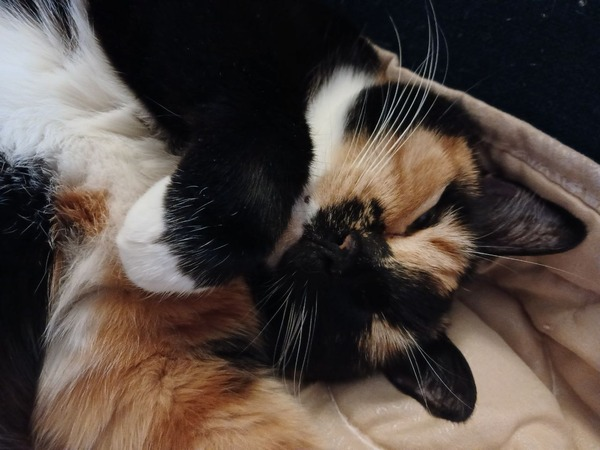

`Пусть будет кот Глеба)`

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

`Кажется это ДЗ получилось самым объёмным из всех, но оно очень классное для проработки всех моментов, что до этого обсуждали на лекциях! Дольше всего пришлось разбираться с shap и lime (как с самим концептом, так и с библиотеками), по общей сложности ДЗ я бы сказал 7. Мне показалось лишним импорты других библиотек (по типу бустингов), в этом ДЗ не используется, поэтому странно их импортировать. Так же не хватило ассертов по трейну в пунктах, где мы работаем с данными (они бы очень пригодились). В целом домашка понравилась, спасибо команде курса!)`